In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 5816464552919355341, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14674281152
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7655830809362321668
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

# imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install --upgrade geopandas
# !pip install --upgrade pyshp
!pip install --upgrade shapely

from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

     |████████████████████████████████| 972kB 15.8MB/s 
     |████████████████████████████████| 14.8MB 228kB/s 
     |████████████████████████████████| 6.5MB 55.1MB/s 
Requirement already up-to-date: shapely in /usr/local/lib/python3.6/dist-packages (1.7.1)


In [ ]:
import scipy.io as scio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

In [ ]:
from keras.utils.np_utils import to_categorical

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, mean_squared_error, mean_absolute_error
from sklearn.externals import joblib

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor

# Data Preprocessing

In [ ]:
inputspath_16 = "/content/drive/My Drive/Colab Notebooks/data/inputs_win16.csv"
labelspath_16 = "/content/drive/My Drive/Colab Notebooks/data/labels_win16.csv"
X_16 = pd.read_csv(inputspath_16)
y_16 = pd.read_csv(labelspath_16)

print(X_16.shape)
print(y_16.shape)

(53440, 16)
(6680, 2)


In [ ]:
np.sum(y_16.iloc[:,0])

1476

In [ ]:
len(y_16.iloc[:,0])

6680

1476/6680

## (6680x96, 6680x1)

In [ ]:
index = np.arange(53440)
sub_idx1 = index[2::8]
sub_idx2 = index[3::8]
sub_idx3 = index[4::8]
sub_idx4 = index[5::8]
sub_idx5 = index[6::8]
sub_idx6 = index[7::8]

X_16 = X_16.values
X_6v = np.empty([0, 96])

for i in range(sub_idx1.shape[0]):
    X_app = np.concatenate((X_16[sub_idx1[i]], X_16[sub_idx2[i]], X_16[sub_idx3[i]], X_16[sub_idx4[i]], X_16[sub_idx5[i]], X_16[sub_idx6[i]]))
    X_app = np.reshape(X_app,(1,96))
    X_6v = np.append(X_6v, X_app, axis=0)
print(X_6v.shape)

print(np.any(np.isnan(X_6v)))
where_are_NaNs = np.isnan(X_6v)
X_6v[where_are_NaNs] = 0
print(np.any(np.isnan(X_6v)))

y = y_16.iloc[:,1].values
print(y.shape)

# now we can use X_6v and y

(53440, 16)
(6680, 2)
(6680, 96)
True
False
(6680,)


In [ ]:
# have a look at window variable
X_6 = np.empty([1, 16])

for i in range(sub_idx5.shape[0]):
    X_app = X_16[sub_idx5[i]]
    X_app = X_app.reshape(1,16)
    X_6 = np.append(X_6, X_app, axis=0)
X_6 = X_6[1:]
print(X_6.shape)

df = pd.DataFrame(X_6)
datapath = "/content/drive/My Drive/Colab Notebooks/X_6.csv"
df.to_csv(datapath)


(6680, 16)


In [ ]:
print(np.sum(X_6))

97000.0


## (8x106880) - training set distribution

In [ ]:
X_16_copy = X_16
print("X_16_copy:",X_16_copy.shape)

temp = []

for i in range(int(X_16_copy.shape[0]/8/2)):
  X_temp = X_16_copy[0:8,:]
  temp.append(X_temp)
  X_16_copy = X_16_copy[16:,:]

print("len temp:",len(temp))

X_T = np.hstack(temp)
X_T[np.isnan(X_T)] = 0
print("X_T:",X_T.shape)

X_16_copy: (53440, 16)
len temp: 3340
X_T: (8, 53440)


In [ ]:
v3 = X_T[2]
v4 = X_T[3]
v5 = X_T[4]
v6 = X_T[5]
v7 = X_T[6]
v8 = X_T[7]

def stat_prop(v):
  print("max:",np.max(v))
  print("min:",np.min(v))
  print("mean:",np.mean(v))
  print("median:",np.median(v))
  print("\n")

stat_prop(v3)
stat_prop(v4)
stat_prop(v5)
stat_prop(v6)
stat_prop(v7)
stat_prop(v8)

max: 26.06167463
min: 12.71263158
mean: 16.683972422319613
median: 15.73


max: 0.010968431
min: -0.000501393
mean: 0.007253460876831962
median: 0.007544828000000001


max: 29.789
min: -0.18600000000000003
mean: 0.9935803517964074
median: 0.45899999999999996


max: 0.8258
min: -5.6433
mean: -0.006315202097732041
median: 0.0285


max: 1.0
min: 0.0
mean: 0.9092065868263473
median: 1.0


max: 1.0
min: 0.0
mean: 0.9998315868263473
median: 1.0




In [ ]:
data_all_T = X_T.T
print("data_all_T:",data_all_T.shape)

data_pd = pd.DataFrame(data_all_T)
data_pd.describe

data_all_T: (53440, 8)


<bound method NDFrame.describe of                 0          1          2         3      4       5    6    7
0      118.724019  21.410248  15.071579  0.007613  1.028  0.2401  1.0  1.0
1      118.725079  21.407787  15.050000  0.007562  1.310  0.1254  1.0  1.0
2      118.726138  21.405327  15.073158  0.007568  1.081  0.2358  1.0  1.0
3      118.727198  21.402866  15.095789  0.007552  1.084  0.1434  1.0  1.0
4      118.728258  21.400406  15.109474  0.007557  1.075  0.0731  1.0  1.0
...           ...        ...        ...       ...    ...     ...  ...  ...
53435   58.983432 -11.264411  13.450000  0.006112  1.353  0.1661  1.0  1.0
53436   58.984367 -11.261921  13.349474  0.005849  1.428  0.1884  1.0  1.0
53437   58.985302 -11.259430  13.264211  0.005628  2.314  0.0743  1.0  1.0
53438   58.986237 -11.256940  13.192105  0.005415  1.781  0.1368  1.0  1.0
53439   58.987172 -11.254449  13.093684  0.005126  1.949  0.0848  1.0  1.0

[53440 rows x 8 columns]>

In [ ]:
data_pd.info

<bound method DataFrame.info of                 0          1          2         3      4       5    6    7
0      118.724019  21.410248  15.071579  0.007613  1.028  0.2401  1.0  1.0
1      118.725079  21.407787  15.050000  0.007562  1.310  0.1254  1.0  1.0
2      118.726138  21.405327  15.073158  0.007568  1.081  0.2358  1.0  1.0
3      118.727198  21.402866  15.095789  0.007552  1.084  0.1434  1.0  1.0
4      118.728258  21.400406  15.109474  0.007557  1.075  0.0731  1.0  1.0
...           ...        ...        ...       ...    ...     ...  ...  ...
53435   58.983432 -11.264411  13.450000  0.006112  1.353  0.1661  1.0  1.0
53436   58.984367 -11.261921  13.349474  0.005849  1.428  0.1884  1.0  1.0
53437   58.985302 -11.259430  13.264211  0.005628  2.314  0.0743  1.0  1.0
53438   58.986237 -11.256940  13.192105  0.005415  1.781  0.1368  1.0  1.0
53439   58.987172 -11.254449  13.093684  0.005126  1.949  0.0848  1.0  1.0

[53440 rows x 8 columns]>

## (13360x96, 13360x1)

In [ ]:
X_16_reversed = np.zeros((53440,16))

for i in range(6680):
  temp = X_16[i,::-1]
  X_16_reversed[i] = temp

print(X_16_reversed.shape)

X_6v_reversed = np.zeros((0,96))

for i in range(sub_idx1.shape[0]):
    X_app = np.concatenate((X_16_reversed[sub_idx1[i]], X_16_reversed[sub_idx2[i]], X_16_reversed[sub_idx3[i]], X_16_reversed[sub_idx4[i]], X_16_reversed[sub_idx5[i]], X_16_reversed[sub_idx6[i]]))
    X_app = np.reshape(X_app,(1,96))
    X_6v_reversed = np.append(X_6v_reversed, X_app, axis=0)
print(X_6v_reversed.shape)

# print(np.any(np.isnan(X_6v_reversed)))
where_are_NaNs = np.isnan(X_6v_reversed)
X_6v_reversed[where_are_NaNs] = 0
# print(np.any(np.isnan(X_6v_reversed)))

# print(X_6v[0])
print(X_6v.shape)
# print(X_6v_reversed[0])
print(X_6v_reversed.shape)

X_augmented = np.vstack((X_6v,X_6v_reversed))

(53440, 16)
(6680, 96)
(6680, 96)
(6680, 96)


In [ ]:
X_augmented.shape

(13360, 96)

In [ ]:
y_reversed = np.zeros(y.shape)
for i in y:
  if y[i]==0:
    y_reversed[i]=0
  else:
    y_reversed[i] = 16+1-y[i]
y_augmented = np.hstack((y,y_reversed))


In [ ]:
y_augmented.shape

(13360,)

## (13360x16x16, 13360x1)

In [ ]:
index = np.arange(53440)
sub_idx1 = index[2::8]
sub_idx2 = index[3::8]
sub_idx3 = index[4::8]
sub_idx4 = index[5::8]
sub_idx5 = index[6::8]
sub_idx6 = index[7::8]

# X_16_reversed = X_16_reversed.values
X_6v = np.empty([0,96])
X_6v_reversed = np.empty([0,96])


for i in range(sub_idx1.shape[0]):
    X_app = np.concatenate((X_16[sub_idx1[i]], X_16[sub_idx2[i]], X_16[sub_idx3[i]], X_16[sub_idx4[i]], X_16[sub_idx5[i]], X_16[sub_idx6[i]]))
    X_app = np.reshape(X_app,(1,96))
    X_6v = np.append(X_6v, X_app, axis=0)
    # print(X_6v.shape)
print("X_6v:",X_6v.shape)

for i in range(sub_idx1.shape[0]):
    X_app = np.concatenate((X_16_reversed[sub_idx1[i]], X_16_reversed[sub_idx2[i]], X_16_reversed[sub_idx3[i]], X_16_reversed[sub_idx4[i]], X_16_reversed[sub_idx5[i]], X_16_reversed[sub_idx6[i]]))
    X_app = np.reshape(X_app,(1,96))
    X_6v_reversed = np.append(X_6v_reversed, X_app, axis=0)
print("X_6v_reversed:",X_6v_reversed.shape)

scaler = StandardScaler()
# X_2D = scaler.fit_transform(X_2D)
# X_2D = X_2D.reshape(X_2D.shape[0],X_2D.shape[1],1)
X_2D = np.zeros((1,16,16))
X_2D_reversed = np.zeros((1,16,16))

for i in range(X_6v.shape[0]):
    temp = X_6v[i]
    t = np.resize(temp, (16,16))
    t[6:, :] = np.zeros((10,16))
    t = scaler.fit_transform(t)
    t = t.reshape(1,16,16)
    X_2D = np.append(X_2D,t,axis=0)

for i in range(X_6v_reversed.shape[0]):
    temp = X_6v_reversed[i]
    t = np.resize(temp, (16,16))
    t[6:, :] = np.zeros((10,16))
    t = scaler.fit_transform(t)
    t = t.reshape(1,16,16)
    X_2D_reversed = np.append(X_2D_reversed,t,axis=0)

X_2D = X_2D[1:, :, :]
X_2D_reversed = X_2D_reversed[1:, :, :]

print("X_2D.shape:",X_2D_reversed.shape)
print("X_2D_reversed.shape:",X_2D_reversed.shape)

X_6v: (6680, 96)
X_6v_reversed: (6680, 96)
X_2D.shape: (6680, 16, 16)
X_2D_reversed.shape: (6680, 16, 16)


In [ ]:
X_2D = np.vstack((X_2D,X_2D_reversed))
print("X_2D.shape:",X_2D.shape)

X_2D.shape: (13360, 16, 16)


In [ ]:
X_2D = X_2D.reshape(13360,16,16,1)
print("X_2D.shape:",X_2D.shape)

X_2D.shape: (13360, 16, 16, 1)


In [ ]:
where_are_NaNs = np.isnan(X_2D)
X_2D[where_are_NaNs] = 0
print("X_2D.shape:",X_2D.shape)

X_2D.shape: (13360, 16, 16, 1)


In [ ]:
y = y_16.iloc[:,1].values
y_reversed = np.zeros(y.shape)
for i in y:
  if y[i]==0:
    y_reversed[i]=0
  else:
    y_reversed[i] = 16+1-y[i]
y_reversed = y_reversed[::-1]
y_2D = np.hstack((y,y_reversed))
print("y_2D.shape:",y_2D.shape)

y_2D.shape: (13360,)


In [ ]:
print(np.sum(y_2D))
print(len(y_2D))
print(np.max(y_2D))

12679.0
13360
16.0


In [ ]:
X_2D[0]

array([[[ 3.85071433],
        [ 3.84561279],
        [ 3.8498967 ],
        [ 3.84988781],
        [ 3.849954  ],
        [ 3.83558122],
        [ 3.84264135],
        [ 3.85098483],
        [ 3.85430958],
        [ 3.83683064],
        [ 3.84087969],
        [ 3.84082758],
        [ 3.83695628],
        [ 3.83995111],
        [ 3.84248459],
        [ 3.84398657]],

       [[-0.3149989 ],
        [-0.31781028],
        [-0.31584799],
        [-0.31409274],
        [-0.31256668],
        [-0.32405102],
        [-0.32310637],
        [-0.31423883],
        [-0.30984488],
        [-0.32566955],
        [-0.32497362],
        [-0.32199208],
        [-0.32387647],
        [-0.32267675],
        [-0.32191588],
        [-0.3208311 ]],

       [[-0.03282629],
        [ 0.04267643],
        [-0.01903624],
        [-0.01701977],
        [-0.01834878],
        [ 0.15382291],
        [ 0.07830121],
        [-0.03570839],
        [-0.10378971],
        [ 0.1420131 ],
        [ 0.09783473],
       

## (13360x16x16,13360x1) - v4

### 1. (8x106880,6680x1)

In [ ]:
X_16_copy = X_16.values

X_li = []

for i in range(int(X_16.shape[0]/8)):
  temp = X_16_copy[0:8,:]
  X_li.append(temp)
  X_16_copy = X_16_copy[8:,:]

X_all = np.hstack(X_li)
print("X_all:",X_all.shape)

X_all: (8, 106880)


In [ ]:
# # new
# X_all = data

### 2. standardization / normalization(minmax)

In [ ]:
X_all_4v = X_all[2:6,:]
X_all_4v[np.isnan(X_all_4v)]=0
print("X_all_4v:",X_all_4v.shape)

X_all_4v_copy = X_all_4v
print("X_all_4v_copy:",X_all_4v_copy.shape)

X_all_4v: (4, 106880)
X_all_4v_copy: (4, 106880)


In [ ]:
# # 第一行
# X_all_4v = X_all_4v.reshape(1,X_all_4v.shape[0])
# X_all_4v.shape

In [ ]:
def stat_prop(data,show_mean=True,show_std=True):
  for i in range(data.shape[0]):
    print("line{}:".format(i+1))
    if show_mean==True:
      print("mean:",np.mean(data[i,:]))
    if show_std==True:
      print("std:",np.std(data[i,:]))
    print("max:",np.max(data[i,:]))
    print("median:",np.median(data[i,:]))
    print("min:",np.min(data[i,:]))
    print("\n")

stat_prop(X_all_4v)

line1:
mean: 16.683767297468375
std: 2.8129187460160634
max: 26.06167463
median: 15.73052632
min: 12.71263158


line2:
mean: 0.007249921846647642
std: 0.001818981136890045
max: 0.0110664
median: 0.0075493719999999995
min: -0.000501393


line3:
mean: 0.9917068862275449
std: 2.6927133288459797
max: 29.789
median: 0.46
min: -0.18600000000000003


line4:
mean: -0.005942960330658686
std: 0.43842686937054776
max: 0.8258
median: 0.028599998999999997
min: -5.6433




In [ ]:
def standardization(data):
  data_li = []
  for i in range(data.shape[0]):
    vi = data[i,:]
    mean = np.mean(vi)
    deviation = np.std(vi)
    vi = (vi-mean)/deviation
    data_li.append(vi)
  data = np.vstack(data_li)
  return data

In [ ]:
def normalization(data):
  data_li = []
  for i in range(data.shape[0]):
    vi = data[i,:]
    max = np.max(vi)
    min = np.min(vi)
    vi = (vi-min)/(max-min)
    data_li.append(vi)
  data = np.vstack(data_li)
  return data

In [ ]:
X_all_4v_standard = standardization(X_all_4v)
# X_all_4v_standard = normalization(X_all_4v)
X_all_4v_standard_copy = X_all_4v_standard
stat_prop(X_all_4v_standard)

print("X_all_4v_standard:",X_all_4v_standard.shape)
print("X_all_4v_standard_copy:",X_all_4v_standard_copy.shape)

line1:
mean: 3.478255607687916e-16
std: 1.0
max: 3.3338706799880207
median: -0.33887967038452527
min: -1.4117491744447628


line2:
mean: 1.0769828143070381e-16
std: 1.0
max: 2.0981405886800353
median: 0.164625210937775
min: -4.2613497685304464


line3:
mean: 4.6935176969183266e-17
std: 0.9999999999999999
max: 10.69452615147642
median: -0.1974613786516292
min: -0.4373680902497989


line4:
mean: 1.143463234943275e-17
std: 0.9999999999999999
max: 1.89710763285288
median: 0.07878841773601201
min: -12.858146782296739


X_all_4v_standard: (4, 106880)
X_all_4v_standard_copy: (4, 106880)


### 3. visualization

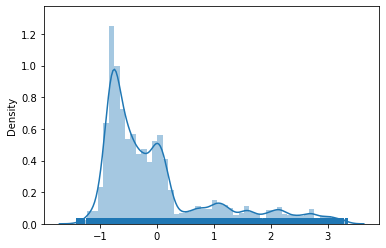

In [ ]:
v0 = X_all_4v_standard[0,:]
sns.distplot(v0, hist=True, rug=True)

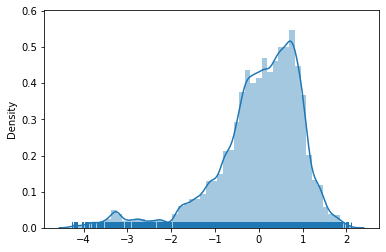

In [ ]:
v1 = X_all_4v_standard[1,:]
sns.distplot(v1, hist=True, rug=True)

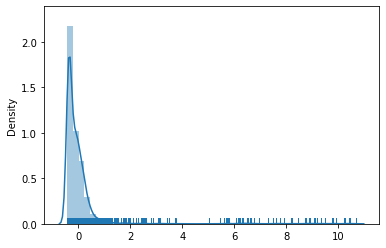

In [ ]:
v2 = X_all_4v_standard[2,:]
sns.distplot(v2, hist=True, rug=True)

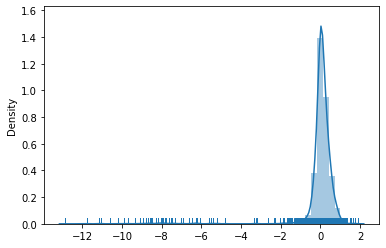

In [ ]:
v3 = X_all_4v_standard[3,:]
sns.distplot(v3, hist=True, rug=True)

### 4. get (X_2D, y_2D)

In [ ]:
X_all_4v_standard_re_li = []

for i in range(X_all_4v_standard.shape[0]):
  vi = X_all_4v_standard[i,:]
  vi_re = vi[::-1]
  X_all_4v_standard_re_li.append(vi_re)

X_all_4v_standard_re = np.vstack(X_all_4v_standard_re_li)
print("X_all_4v_standard_re:",X_all_4v_standard_re.shape)

X_all_4v_standard_aug = np.hstack((X_all_4v_standard,X_all_4v_standard_re))
print("X_all_4v_standard_aug:",X_all_4v_standard_aug.shape)

X_all_4v_standard_aug_copy = X_all_4v_standard_aug
print("X_all_4v_standard_aug_copy:",X_all_4v_standard_aug_copy.shape)

X_all_4v_standard_re: (4, 106880)
X_all_4v_standard_aug: (4, 213760)
X_all_4v_standard_aug_copy: (4, 213760)


In [ ]:
y = y_16.values[:,1]
y_re = y[::-1]
print("y_re:",y_re.shape)

# print(y[6])   # 5
# print(y_re[-7]) # 5

y_2D = np.hstack((y,y_re))
print("y_2D:",y_2D.shape)

print(y_2D[6])   # 5
print(y_2D[-7])  # 5

y_re: (6680,)
y_2D: (13360,)
5
5


In [ ]:
X_list = []
Z = np.zeros((12,16))

scaler = StandardScaler()

for i in range(int(X_all_4v_standard_aug.shape[1]/16)):
  temp = X_all_4v_standard_aug[:,0:16]
  temp = np.vstack((temp,Z))
  temp = scaler.fit_transform(temp)
  temp = temp.reshape(16,16,1)
  X_all_4v_standard_aug = X_all_4v_standard_aug[:,16:]
  X_list.append(temp)

print("len X_list:",len(X_list))

X_all_4v_standard_aug = X_all_4v_standard_aug_copy
print("X_all_4v_standard_aug:",X_all_4v_standard_aug.shape)

X_2D = np.stack(X_list,axis=0)
print("X_2D:",X_2D.shape)

# # new
# y_2D = y_aug
# # new
print("y_2D:",y_2D.shape)

len X_list: 13360
X_all_4v_standard_aug: (4, 213760)
X_2D: (13360, 16, 16, 1)
y_2D: (13360,)


In [ ]:
# get y_prob for 17 categories
y_prob = to_categorical(y_2D, num_classes=None)

y_prob.shape

(13360, 17)

## (13360x16x16,13360x1) - classification

In [ ]:
X_cls = X_2D
print("X_cls:",X_cls.shape)

y_cls = np.zeros(y_2D.shape)
for i in range(len(y_2D)):
  if y_2D[i]==0:
    y_cls[i]=0
  else:
    y_cls[i]=1
print("y_cls:",y_cls.shape)
print(np.sum(y_cls))

X_cls: (13360, 16, 16, 1)
y_cls: (13360,)
2952.0


## Testing

In [ ]:
index = np.arange(53440)
sub_idx = index[0::8]
sub_idy = index[1::8]

X_16_np = X_16.values

X_2v = np.empty([2,16])
X_2v_reversed = np.empty([2,16])
location_2v = []

for i in range(sub_idx.shape[0]):
    X_app = np.vstack((X_16_np[sub_idx[i]], X_16_np[sub_idy[i]]))
    # print("X_app:",X_app.shape)
    for j in range(16):
      location_2v.append((X_app[0,j],X_app[1,j]))
    # print(location_2v)

print(len(location_2v))

106880


In [ ]:
location_2v_reversed = location_2v[::-1]
print("location_2v_reversed:",len(location_2v_reversed))
print(location_2v[0])
print(location_2v_reversed[-1])

location_2v_reversed: 106880
(118.724019, 21.410248)
(118.724019, 21.410248)


In [ ]:
location_2v.extend(location_2v_reversed)
print("location_2v",len(location_2v))
print(location_2v[0])
print(location_2v[-1])

location_2v 213760
(118.724019, 21.410248)
(118.724019, 21.410248)


# Data with wind

In [ ]:
data = np.load("/content/drive/My Drive/Colab Notebooks/data/Trainingdata_U_NoSmSwhSSh/data.npy")
data.shape

(9, 88576)

In [ ]:
y = np.load("/content/drive/My Drive/Colab Notebooks/data/Trainingdata_U_NoSmSwhSSh/data.npy")
y.shape

(9, 88576)

## load

In [ ]:
def process(inputspath, labelspath):
    inputs = []
    labels = []
    inputfilenames = os.listdir(inputspath)
    labelfilenames = os.listdir(labelspath)
    
    for file in inputfilenames:
        readpath = inputspath + file
        input = scio.loadmat(readpath)
        input = input['inputs']
        inputs.append(input)
    
    for file in labelfilenames:
        readpath = labelspath + file
        label = scio.loadmat(readpath)
        label = label['outputs']
        label = label[0]
        labels.extend(label)
    
    return np.array(inputs), np.array(labels)

In [ ]:
inputspath = "/content/drive/My Drive/Colab Notebooks/data/Trainingdata_U_NoSmSwhSSh/inputs/"
labelspath = "/content/drive/My Drive/Colab Notebooks/data/Trainingdata_U_NoSmSwhSSh/labels/"

inputs, labels = process(inputspath, labelspath)

data = np.hstack(inputs)
print(data.shape)

labels = labels.reshape(-1,1)
print(len(labels))

(9, 88576)
88576


In [ ]:
np.save("/content/drive/My Drive/Colab Notebooks/data/Trainingdata_U_NoSmSwhSSh/data.npy", data)
np.save("/content/drive/My Drive/Colab Notebooks/data/Trainingdata_U_NoSmSwhSSh/labels.npy", labels)

# data = np.load("/content/drive/My Drive/Colab Notebooks/data/Trainingdata_U_NoSmSwhSSh/data.npy")
# labels = np.load("/content/drive/My Drive/Colab Notebooks/data/Trainingdata_U_NoSmSwhSSh/labels.npy")

print(data.shape)
print(len(labels))

(9, 88576)
88576


In [ ]:
data_first = data[:,0:16]
print(data_first.shape)
data_first

(9, 16)


array([[ 1.19762755e+02,  1.19763651e+02,  1.19764548e+02,
         1.19765445e+02,  1.19766341e+02,  1.19767238e+02,
         1.19768135e+02,  1.19769031e+02,  1.19769928e+02,
         1.19770825e+02,  1.19771721e+02,  1.19772618e+02,
         1.19773514e+02,  1.19774411e+02,  1.19775308e+02,
         1.19776204e+02],
       [ 3.98266600e+00,  3.98016600e+00,  3.97766600e+00,
         3.97516600e+00,  3.97266600e+00,  3.97016600e+00,
         3.96766600e+00,  3.96516600e+00,  3.96266600e+00,
         3.96016600e+00,  3.95766600e+00,  3.95516600e+00,
         3.95266600e+00,  3.95016600e+00,  3.94766600e+00,
         3.94516600e+00],
       [ 1.48206667e+01,  1.47517647e+01,  1.47363158e+01,
         1.46784211e+01,  1.46389474e+01,  1.46094737e+01,
         1.45752632e+01,  1.45378947e+01,  1.45315789e+01,
         1.45347368e+01,  1.44547368e+01,  1.44589474e+01,
         1.45110526e+01,  1.45168421e+01,  1.45357895e+01,
         1.45642105e+01],
       [-1.01231501e-03, -8.31019580e

## data_aug

In [ ]:
def standardization(data):
  data_li = []
  for i in range(data.shape[0]):
    vi = data[i,:]
    mean = np.mean(vi)
    deviation = np.std(vi)
    vi = (vi-mean)/deviation
    data_li.append(vi)
  data = np.vstack(data_li)
  return data

def minus_mean(data):
  data_li = []
  for i in range(data.shape[0]):
    vi = data[i,:]
    vi = vi-np.mean(vi)
    data_li.append(vi)
  data = np.vstack(data_li)
  return data

In [ ]:
def stat_prop(data,show_mean=True,show_std=True):
  for i in range(data.shape[0]):
    print("line{}:".format(i+1))
    if show_mean==True:
      print("mean:",np.mean(data[i,:]))
    if show_std==True:
      print("std:",np.std(data[i,:]))
    print("max:",np.max(data[i,:]))
    print("median:",np.median(data[i,:]))
    print("min:",np.min(data[i,:]))
    print("\n")
data[np.isnan(data)]=0
stat_prop(data)
data.shape

line1:
mean: 110.65741649529214
std: 12.414551960298317
max: 120.721938
median: 118.28058999999999
min: 58.855128


line2:
mean: 8.449633776034139
std: 5.132285090930314
max: 22.204347
median: 7.561386
min: -11.605566999999999


line3:
mean: 16.829034570449625
std: 3.0453579136654834
max: 26.06167462983867
median: 15.483684210526318
min: 12.712631578947365


line4:
mean: -0.0016611221407125904
std: 0.0013347813343741138
max: 0.0038373978315262456
median: -0.0017192186000212842
min: -0.006937045207599354


line5:
mean: 0.019432498979051017
std: 1.6734166168442384
max: 17.231182178976077
median: -0.16620202020202018
min: -10.78586483136298


line6:
mean: -0.0047900446667439546
std: 0.28181142083879474
max: 2.1682479516026936
median: 0.0
min: -3.5118845427927186


line7:
mean: 0.892634573699422
std: 0.30957727877845487
max: 1.0
median: 1.0
min: 0.0


line8:
mean: 0.9998983923410405
std: 0.010079550329413423
max: 1.0
median: 1.0
min: 0.0


line9:
mean: 2.883049905228438
std: 1.881892282031

(9, 88576)

In [ ]:
data_copy = data[2:6, :]
# data_copy = data_copy.reshape(1, data_copy.shape[0])

# wind = data[-1,:]
# data_copy = np.vstack([data_copy, wind])

data_copy = standardization(data_copy)
# data_copy[0,:] = (data_copy[0,:] - np.mean(data_copy[0,:])) / np.std(data_copy[0,:])
stat_prop(data_copy)

print(data_copy.shape)
# data_copy

line1:
mean: -2.669669238405001e-16
std: 1.0
max: 3.0317093494854155
median: -0.4417708519206543
min: -1.3516976027778738


line2:
mean: -3.850484478468751e-18
std: 1.0
max: 4.119416289872769
median: -0.04352507621477609
min: -3.952649719484332


line3:
mean: 7.059221543859376e-18
std: 1.0
max: 10.28539426867607
median: -0.11093144248271204
min: -6.457027629329312


line4:
mean: 2.8076449322167977e-18
std: 0.9999999999999999
max: 7.7109649772231394
median: 0.016997340464366826
min: -12.444827422846522


(4, 88576)


In [ ]:
data_copy.shape

(4, 88576)

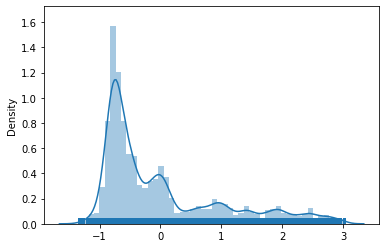

In [ ]:
v0 = data_copy[0,:]
sns.distplot(v0, hist=True, rug=True)

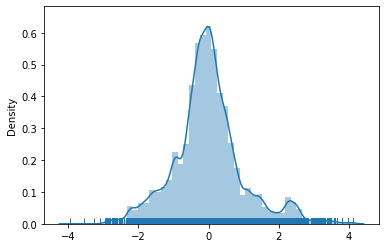

In [ ]:
v1 = data_copy[1,:]
sns.distplot(v1, hist=True, rug=True)

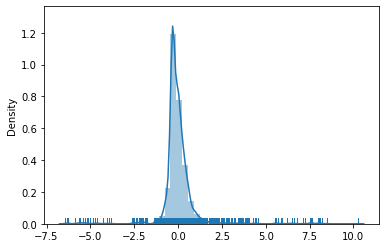

In [ ]:
v2 = data_copy[2,:]
sns.distplot(v2, hist=True, rug=True)

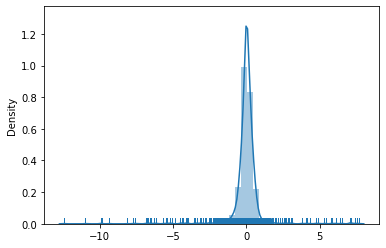

In [ ]:
v3 = data_copy[3,:]
sns.distplot(v3, hist=True, rug=True)

In [ ]:
data_re_li = []
for i in range(data_copy.shape[0]):
  vi = data_copy[i, :]
  vi_re = vi[::-1]
  data_re_li.append(vi_re)

data_copy_re = np.vstack(data_re_li)
print("data_copy_re: ", data_copy_re.shape)

data_copy_aug = np.hstack((data_copy, data_copy_re))
data_copy_aug_1 = data_copy_aug
print("data_copy_aug: ", data_copy_aug.shape)


data_copy_re:  (4, 88576)
data_copy_aug:  (4, 177152)


In [ ]:
Z = np.zeros((12,16))
print(Z.shape)

scaler = StandardScaler()
data_li_1 = []
for i in range(int(data_copy_aug.shape[1]/16)):
  temp = data_copy_aug[:, :16]
  temp = np.vstack((temp, Z))
  temp = scaler.fit_transform(temp)
  temp = temp.reshape(16, 16, 1)
  data_li_1.append(temp)
  data_copy_aug = data_copy_aug[:, 16:]

print("len data_li_1: ", len(data_li_1))

data_aug = np.stack(data_li_1,axis=0)
print("data_aug: ", data_aug.shape)

data_copy_aug = data_copy_aug_1

(12, 16)
len data_li_1:  11072
data_aug:  (11072, 16, 16, 1)


## y_aug - 1193/5536

In [ ]:
for i in range(len(labels)):
  if labels[i]==1:
    break
print(i)

60


In [ ]:
np.sum(labels)

1193

In [ ]:
len(labels)/16

5536.0

In [ ]:
np.argwhere(labels==1)

array([[   60,     0],
       [  112,     0],
       [  155,     0],
       ...,
       [88381,     0],
       [88440,     0],
       [88498,     0]])

In [ ]:
x = labels[48:64]
np.sum(x)

1

In [ ]:
y = []
labels_copy = labels
for i in range(int(len(labels_copy)/16)):
  temp = labels_copy[0:16]
  if np.sum(temp)==0:
    j = 0
  else:
    j = np.argwhere(temp==1)[0][0]+1
  y.append(j)
  labels_copy = labels_copy[16:]
print(y)

[0, 0, 0, 13, 0, 0, 0, 1, 0, 12, 0, 0, 0, 0, 5, 0, 11, 0, 0, 0, 0, 4, 0, 0, 0, 15, 0, 0, 0, 0, 8, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 15, 0, 0, 12, 0, 0, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 9, 0, 0, 6, 0, 0, 0, 0, 12, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 12, 0, 0, 0, 0, 5, 0, 0, 0, 16, 0, 0, 0, 15, 0, 0, 0, 6, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 6, 0, 0, 3, 0, 0, 0, 0, 0, 0, 9, 0, 0, 4, 0, 0, 0, 13, 0, 0, 0, 1, 0, 0, 0, 15, 0, 0, 13, 0, 0, 10, 6, 0, 0, 0, 0, 11, 0, 0, 0, 0, 0, 0, 0, 11, 0, 0, 0, 0, 4, 0, 0, 0, 0, 9, 0, 0, 9, 0, 0, 13, 0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 5, 0, 0, 0, 14, 0, 0, 0, 0, 0, 7, 0, 0, 5, 0, 0, 9, 0, 0, 4, 0, 0, 0, 0, 0, 0, 13, 0, 0, 0, 0, 0, 5, 0, 0, 9, 0, 0, 7, 0, 0, 0, 13, 0, 0, 0, 0, 0, 5, 0, 0, 3, 0, 16, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 7, 0, 0, 11, 0, 0, 16, 0, 0, 0, 0, 0, 0, 10, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 15, 0, 0, 13, 0, 0, 10, 0, 0, 0, 9, 0, 0, 7, 0, 0, 0, 7, 0, 0,

In [ ]:
y_re = []
labels_copy_re = labels[::-1]
for i in range(int(len(labels_copy_re)/16)):
  temp = labels_copy_re[0:16]
  if np.sum(temp)==0:
    j = 0
  else:
    j = np.argwhere(temp==1)[0][0]+1
  y_re.append(j)
  labels_copy_re = labels_copy_re[16:]
print(y_re)

[0, 0, 0, 0, 14, 0, 0, 0, 8, 0, 0, 0, 3, 0, 0, 0, 0, 0, 6, 0, 0, 0, 13, 0, 0, 0, 0, 0, 4, 0, 0, 0, 8, 0, 0, 0, 0, 0, 0, 0, 0, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 11, 0, 0, 0, 6, 9, 0, 0, 0, 4, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 7, 0, 0, 0, 14, 0, 0, 0, 0, 2, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 16, 0, 0, 0, 11, 0, 0, 2, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 15, 0, 0, 0, 0, 2, 0, 0, 13, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 0, 16, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 14, 0, 0, 0, 0, 13, 0, 0, 0, 8, 0, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 16, 0, 0, 0, 0, 0, 0, 0, 15, 0, 0, 0, 0, 6, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 1, 0, 0, 12, 0, 0, 0, 0, 10, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 8, 0, 0, 0, 0, 16, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0, 12, 0, 0, 0, 0,

In [ ]:
y.extend(y_re)
y

[0,
 0,
 0,
 13,
 0,
 0,
 0,
 1,
 0,
 12,
 0,
 0,
 0,
 0,
 5,
 0,
 11,
 0,
 0,
 0,
 0,
 4,
 0,
 0,
 0,
 15,
 0,
 0,
 0,
 0,
 8,
 0,
 0,
 0,
 0,
 0,
 7,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 9,
 0,
 0,
 0,
 0,
 0,
 0,
 15,
 0,
 0,
 12,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 10,
 0,
 0,
 0,
 0,
 0,
 9,
 0,
 0,
 6,
 0,
 0,
 0,
 0,
 12,
 0,
 0,
 0,
 0,
 0,
 8,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 0,
 0,
 0,
 12,
 0,
 0,
 0,
 0,
 5,
 0,
 0,
 0,
 16,
 0,
 0,
 0,
 15,
 0,
 0,
 0,
 6,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 6,
 0,
 0,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 9,
 0,
 0,
 4,
 0,
 0,
 0,
 13,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 15,
 0,
 0,
 13,
 0,
 0,
 10,
 6,
 0,
 0,
 0,
 0,
 11,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 11,
 0,
 0,
 0,
 0,
 4,
 0,
 0,
 0,
 0,
 9,
 0,
 0,
 9,
 0,
 0,
 13,
 0,
 0,
 0,
 0,
 3,
 0,
 0,
 1,
 0,
 0,
 0,
 5,
 0,
 0,
 0,
 14,
 0,
 0,
 0,
 0,
 0,
 7,
 0,
 0,
 5,
 0,
 0,
 9,
 0,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 13,
 0,
 0,
 0,
 0,
 0,
 5,
 0,
 0,
 9,


In [ ]:
len(y)

11072

In [ ]:
y_aug_p = np.hstack(y)
print("y_aug_p: ", y_aug_p.shape)

y_aug_p:  (11072,)


In [ ]:
print(y[3])
print(y_re[-4])

13
4


In [ ]:
y_aug = to_categorical(y_aug_p, num_classes=None)

y_aug

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
print(y_aug[3])
print(y_aug[-4])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
y_aug.shape

(11072, 17)

## save and load

In [ ]:
np.save("data_aug.npy",data_aug)
np.save("y_aug.npy",y_aug)

data_aug =  np.load("data_aug.npy")
y_aug =  np.load("y_aug.npy")

In [ ]:
print(data_aug.shape)
print(y_aug.shape)

(11072, 16, 16, 1)
(11072, 17)


In [ ]:
print(y_aug[3])
print(y_aug[-4])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


# Hyper-parameter tuning

In [ ]:
X_train_16, X_test_16, y_train_16, y_test_16 = train_test_split( X_augmented, y_augmented, test_size=0.1)

scaler=StandardScaler()
X_train_16=scaler.fit_transform(X_train_16)
X_test_16=scaler.transform(X_test_16)

LGB = LGBMRegressor(n_jobs=-1,colsample_bytree=0.6)

param_grid = {
        "n_estimators": [350,400,450],
        "learning_rate": [0.10],
        "num_leaves": [32],
        "max_depth": [16],
        "min_child_samples": [8]
        }
LGB_grid = RandomizedSearchCV(LGB, param_grid, cv=10)
LGB_grid.fit(X_train_16,y_train_16)
best_est_LGB = LGB_grid.best_estimator_ 

best_est_LGB.fit(X_train_16,y_train_16)

y_pred = best_est_LGB.predict(X_test_16)

print('Best parameters:', LGB_grid.best_params_)
print('MSE: {:.4f}'.format(mean_squared_error(y_test_16, y_pred)))
print('MAE: {:.4f}'.format(mean_absolute_error(y_test_16, y_pred)))

print('----------------------------------------------------------------------------------------------------------------------')

Best parameters: {'num_leaves': 32, 'n_estimators': 400, 'min_child_samples': 8, 'max_depth': 16, 'learning_rate': 0.1}
MSE: 1.2126
MAE: 0.3102
----------------------------------------------------------------------------------------------------------------------


# LightGBM

In [ ]:
LGB_Acc = []
LGB_MSE = []
LGB_MAE = []

for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split( X_augmented, y_augmented, test_size=0.1)

    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)
    X_test=scaler.transform(X_test)

    # max_depth=20
    LGB = LGBMRegressor(n_jobs=-1,num_leaves=32,n_estimators=350,learning_rate=0.1,min_child_samples=8,max_depth=16,colsample_bytree=0.6)
    # LGB = best_est_LGB

    LGB.fit(X_train,y_train)

    # predict
    y_pred = LGB.predict(X_test)
    print(i, ":")
    print("MSE: ",mean_squared_error(y_test, y_pred))
    print("MAE: ", mean_absolute_error(y_test, y_pred))

    # round
    y_pred = np.around(y_pred)
    y_pred = y_pred.astype(int)

    round_diff = np.zeros(len(y_test))
    for i in range(len(y_test)):
      if y_pred[i]==0 and y_test[i]==0:
        round_diff[i]=1
      elif y_pred[i]!=0 and y_test[i]!=0 and abs(y_pred[i]-y_test[i])<=5:
        round_diff[i]=1
      else:
        round_diff[i]=0

    # +- 5 pixels are regarded as correctly-classified
    acc = np.count_nonzero(round_diff)/len(y_test)
    print("acc: ", acc)

    print("\n")

    LGB_MSE.append(mean_squared_error(y_test, y_pred))
    LGB_MAE.append(mean_absolute_error(y_test, y_pred))
    LGB_Acc.append(acc)

0 :
MSE:  2.357886990388221
MAE:  0.4017096699995198
acc:  0.9079341317365269


1 :
MSE:  1.6850625813445543
MAE:  0.3435910152700653
acc:  0.9131736526946108


2 :
MSE:  2.2555915761775416
MAE:  0.3826788424099425
acc:  0.8982035928143712


3 :
MSE:  1.4816353609611703
MAE:  0.33778708527175855
acc:  0.9109281437125748


4 :
MSE:  1.6766445173307414
MAE:  0.34079450064587474
acc:  0.9199101796407185


5 :
MSE:  2.172098850504425
MAE:  0.3997556796513348
acc:  0.9079341317365269


6 :
MSE:  1.5026479842980647
MAE:  0.33038831274968655
acc:  0.9199101796407185


7 :
MSE:  2.126102773970701
MAE:  0.39485827666614265
acc:  0.9004491017964071


8 :
MSE:  1.7178186248913494
MAE:  0.37699832131632305
acc:  0.906437125748503


9 :
MSE:  1.8770264429666497
MAE:  0.3733745854988224
acc:  0.9161676646706587


10 :
MSE:  2.081303534454463
MAE:  0.379699969858621
acc:  0.9079341317365269


11 :
MSE:  1.7500174224803136
MAE:  0.3365919434270504
acc:  0.9176646706586826


12 :
MSE:  1.93385815741361

In [ ]:
print("Acc: ",np.mean(LGB_Acc))
print("MSE: ",np.mean(LGB_MSE))
print("MAE: ",np.mean(LGB_MAE))

Acc:  0.9079865269461077
MSE:  1.8766467065868264
MAE:  0.32369760479041915


## exp

### 前两行

In [ ]:
def exp(X, y):
  X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.1)

  # scaler=StandardScaler()
  # X_train=scaler.fit_transform(X_train)
  # X_test=scaler.transform(X_test)

  # max_depth=20
  # LGB = LGBMClassifier(n_jobs=-1,num_leaves=32,n_estimators=400,learning_rate=0.1,min_child_samples=8,max_depth=16,colsample_bytree=0.6)
  LGB = LGBMClassifier()
  # LGB = best_est_LGB

  LGB.fit(X_train,y_train)

  # predict
  y_pred = LGB.predict(X_test)
  # y_pred_cls = np.argmax(y_pred, axis=-1)
  # y_test_cls = np.argmax(y_test, axis=-1)
  
  print("Val Acc:{}".format(np.around(accuracy_score(y_test, y_pred),4)))

  tp1=0
  tn1=0
  fp1=0
  fn1=0

  # <=5 then 0
  diff_cls = np.zeros(len(y_test))
  for i in range(len(y_test)):
    if y_pred[i]==0 and y_test[i]==0:
      diff_cls[i]=1
      tn1=tn1+1
    elif y_pred[i]!=0 and y_test[i]!=0 and abs(y_pred[i]-y_test[i])<=5:
      diff_cls[i]=1
      tp1=tp1+1
    else:
      diff_cls[i]=0
      if y_pred[i]==0 and y_test[i]!=0:
        fn1=fn1+1
      else:
        fp1=fp1+1

  # +- 5 pixels are regarded as correctly-classified
  acc = np.count_nonzero(diff_cls)/len(y_test)
  print("Rounded Acc:{}".format(np.around(acc,4)))
  print("Precision:{} TP/(TP+FP)".format(np.around(tp1/(tp1+fp1),4)))
  print("Recall:{} TP/(TP+FN)".format(np.around(tp1/(tp1+fn1),4)))
  print("TP:{} FN:{}\nFP:{} TN:{}".format(tp1,fn1,fp1,tn1))


In [ ]:
print(X_2D.shape, y_2D.shape)
print(data_aug.shape, y_aug_p.shape)

(13360, 16, 16) (13360,)
(11072, 16, 16) (11072,)


In [ ]:
X_2D = X_2D.reshape(13360,16,16)
li = []
for i in range(13360):
  temp = X_2D[i]
  temp = np.hstack((temp[0,:],temp[1,:]))
  li.append(temp)

X_2D_exp = np.vstack(li)
print(X_2D_exp.shape)
print(y_2D.shape)

data_aug = data_aug.reshape(11072,16,16)
li = []
for i in range(11072):
  temp = data_aug[i]
  temp = np.hstack((temp[0,:],temp[1,:]))
  li.append(temp)

data_aug_exp = np.vstack(li)
print(data_aug_exp.shape)
print(y_aug_p.shape)

(13360, 32)
(13360,)
(11072, 32)
(11072,)


In [ ]:
exp(X_2D_exp,y_2D)
print("\n")
exp(data_aug_exp,y_aug_p)

Val Acc:0.9087
Rounded Acc:0.9139
Precision:0.9037 TP/(TP+FP)
Recall:0.677 TP/(TP+FN)
TP:197 FN:94
FP:21 TN:1024


Val Acc:0.7031
Rounded Acc:0.713
Precision:0.1212 TP/(TP+FP)
Recall:0.0734 TP/(TP+FN)
TP:16 FN:202
FP:116 TN:774


### 后两行

In [ ]:
X_2D = X_2D.reshape(13360,16,16)
li = []
for i in range(13360):
  temp = X_2D[i]
  temp = np.hstack((temp[2,:],temp[3,:]))
  li.append(temp)

X_2D_exp = np.vstack(li)
print(X_2D_exp.shape)
print(y_2D.shape)

(13360, 32)
(13360,)


In [ ]:
data_aug = data_aug.reshape(11072,16,16)
li = []
for i in range(11072):
  temp = data_aug[i]
  temp = np.hstack((temp[2,:],temp[3,:]))
  li.append(temp)

data_aug_exp = np.vstack(li)
print(data_aug_exp.shape)
print(y_aug_p.shape)

(11072, 32)
(11072,)


In [ ]:
exp(X_2D_exp,y_2D)
print("\n")
exp(data_aug_exp,y_aug_p)

Val Acc:0.9079
Rounded Acc:0.9079
Precision:0.9454 TP/(TP+FP)
Recall:0.6049 TP/(TP+FN)
TP:173 FN:113
FP:10 TN:1040


Val Acc:0.7247
Rounded Acc:0.7347
Precision:0.1368 TP/(TP+FP)
Recall:0.0578 TP/(TP+FN)
TP:13 FN:212
FP:82 TN:801


### 第一行


In [ ]:
print(X_2D.shape, y_2D.shape)
print(data_aug.shape, y_aug_p.shape)

(13360, 16, 16) (13360,)
(11072, 16, 16) (11072,)


In [ ]:
X_2D = X_2D.reshape(13360,16,16)
li = []
for i in range(13360):
  temp = X_2D[i]
  # print(temp.shape)
  temp = temp[0,:]
  # temp = np.hstack((temp[0,:],temp[1,:]))
  li.append(temp)

X_2D_exp = np.vstack(li)
print(X_2D_exp.shape)
print(y_2D.shape)

data_aug = data_aug.reshape(11072,16,16)
li = []
for i in range(11072):
  temp = data_aug[i]
  # temp = np.hstack((temp[0,:],temp[1,:]))
  temp = temp[0,:]
  li.append(temp)

data_aug_exp = np.vstack(li)
print(data_aug_exp.shape)
print(y_aug_p.shape)

exp(X_2D_exp,y_2D)
print("\n")
exp(data_aug_exp,y_aug_p)

(13360, 16)
(13360,)
(11072, 16)
(11072,)
Val Acc:0.8817
Rounded Acc:0.8907
Precision:0.8482 TP/(TP+FP)
Recall:0.6291 TP/(TP+FN)
TP:190 FN:112
FP:34 TN:1000


Val Acc:0.7365
Rounded Acc:0.7437
Precision:0.1512 TP/(TP+FP)
Recall:0.058 TP/(TP+FN)
TP:13 FN:211
FP:73 TN:811


### all

In [ ]:
X_2D.reshape(X_2D.shape[0],16,16)
data_aug.reshape(data_aug.shape[0],16,16)

y_2D.reshape(y_2D.shape[0],1)
y_aug_p.reshape(y_aug_p.shape[0],1)

print(X_2D.shape, y_2D.shape)
print(data_aug.shape, y_aug_p.shape)

(13360, 16, 16) (13360,)
(11072, 16, 16) (11072,)


In [ ]:
X_2D = X_2D.reshape(13360,16,16)
li = []
for i in range(13360):
  temp = X_2D[i]
  temp = np.hstack((temp[0,:],temp[1,:],temp[2,:],temp[3,:]))
  li.append(temp)

X_2D_exp = np.vstack(li)
print(X_2D_exp.shape)
print(y_2D.shape)

data_aug = data_aug.reshape(11072,16,16)
li = []
for i in range(11072):
  temp = data_aug[i]
  temp = np.hstack((temp[0,:],temp[1,:],temp[2,:],temp[3,:]))
  li.append(temp)

data_aug_exp = np.vstack(li)
print(data_aug_exp.shape)
print(y_aug_p.shape)

(13360, 64)
(13360,)
(11072, 64)
(11072,)


In [ ]:
exp(X_2D_exp, y_2D)
print()
exp(data_aug_exp, y_aug_p)

Val Acc:0.9027
Rounded Acc:0.9027
Precision:0.9119 TP/(TP+FP)
Recall:0.653 TP/(TP+FN)
TP:207 FN:110
FP:20 TN:999

Val Acc:0.7175
Rounded Acc:0.7238
Precision:0.0935 TP/(TP+FP)
Recall:0.0457 TP/(TP+FN)
TP:10 FN:209
FP:97 TN:792


In [ ]:
# scaled
Val Acc:0.7157
Rounded Acc:0.7238
Precision:0.1667 TP/(TP+FP)
Recall:0.0714 TP/(TP+FN)
TP:17 FN:221
FP:85 TN:785

# non-scaled
Val Acc:0.7301
Rounded Acc:0.7401
Precision:0.1188 TP/(TP+FP)
Recall:0.0569 TP/(TP+FN)
TP:12 FN:199
FP:89 TN:808

# scaled
Val Acc:0.9087
Rounded Acc:0.9087
Precision:0.8924 TP/(TP+FP)
Recall:0.67 TP/(TP+FN)
TP:199 FN:98
FP:24 TN:1015

# unscaled
Val Acc:0.9012
Rounded Acc:0.9012
Precision:0.9114 TP/(TP+FP)
Recall:0.6606 TP/(TP+FN)
TP:216 FN:111
FP:21 TN:988

## Save and load model

In [ ]:


X_train, X_test, y_train, y_test = train_test_split( X_augmented, y_augmented, test_size=0.1)

scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

# max_depth=20
LGB = LGBMRegressor(n_jobs=-1,num_leaves=32,n_estimators=400,learning_rate=0.1,min_child_samples=8,max_depth=16,colsample_bytree=0.6)
# LGB = best_est_LGB

LGB.fit(X_train,y_train)

# predict
y_pred = LGB.predict(X_test)
print("MSE: ",mean_squared_error(y_test, y_pred))
print("MAE: ", mean_absolute_error(y_test, y_pred))

# round
y_pred = np.around(y_pred)
y_pred = y_pred.astype(int)

round_diff = np.zeros(len(y_test))
for i in range(len(y_test)):
  if y_pred[i]==0 and y_test[i]==0:
    round_diff[i]=1
  elif y_pred[i]!=0 and y_test[i]!=0 and abs(y_pred[i]-y_test[i])<=5:
    round_diff[i]=1
  else:
    round_diff[i]=0

# +- 5 pixels are regarded as correctly-classified
acc = np.count_nonzero(round_diff)/len(y_test)
print("acc: ", acc)

joblib.dump(LGB,'LGB.pkl')

MSE:  1.5445960559250733
MAE:  0.30359488607273327
acc:  0.9169161676646707


['LGB.pkl']

In [ ]:
joblib.dump(LGB,"/content/drive/My Drive/Colab Notebooks/LGB.pkl")

['/content/drive/My Drive/Colab Notebooks/LGB.pkl']

In [ ]:
# Loading saved model

LGB_loaded = joblib.load("/content/drive/My Drive/Colab Notebooks/LGB.pkl")

# predict
y_pred = LGB.predict(X_test)
print("MSE: ",mean_squared_error(y_test, y_pred))
print("MAE: ", mean_absolute_error(y_test, y_pred))

# round
y_pred = np.around(y_pred)
y_pred = y_pred.astype(int)

round_diff = np.zeros(len(y_test))
for i in range(len(y_test)):
  if y_pred[i]==0 and y_test[i]==0:
    round_diff[i]=1
  elif y_pred[i]!=0 and y_test[i]!=0 and abs(y_pred[i]-y_test[i])<=5:
    round_diff[i]=1
  else:
    round_diff[i]=0

# +- 5 pixels are regarded as correctly-classified
acc = np.count_nonzero(round_diff)/len(y_test)
print("acc: ", acc)

MSE:  1.5445960559250733
MAE:  0.30359488607273327
acc:  0.9169161676646707


# CNN - 2D data with augmentation

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential,activations
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization,Dropout,Dense,Flatten,Conv1D,Conv2D,MaxPooling1D,MaxPooling2D,GlobalMaxPooling2D,AveragePooling2D,Activation,Input,Add,Dense,ZeroPadding2D,Flatten,MultiHeadAttention
from tensorflow.keras.optimizers import Adam,RMSprop,SGD
from keras.initializers import glorot_uniform
from keras.models import Model
from keras import metrics
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

import matplotlib.pyplot as plt
%matplotlib inline

def mySigmoid(x):
  output = K.sigmoid(x)*16
  # output._keras_logits = x
  return output

get_custom_objects().update({'mySigmoid': mySigmoid})

In [ ]:
def plotLearningCurve_cls(history,epochs):
  epochRange = range(1,epochs+1)
  plt.plot(epochRange,history.history['accuracy'])
  plt.plot(epochRange,history.history['val_accuracy'])
  plt.title('Model Acc')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Train Acc','Validation Acc'],loc='upper left')
  plt.show()

  plt.plot(epochRange,history.history['loss'])
  plt.plot(epochRange,history.history['val_loss'])
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Train','Validation'],loc='upper left')
  
  plt.show()

  # def plotLearningCurve(history,epochs):
  # epochRange = range(1,epochs+1)
  # plt.plot(epochRange,history.history['mean_squared_error'])
  # plt.plot(epochRange,history.history['mean_absolute_error'])
  # plt.plot(epochRange,history.history['val_mean_squared_error'])
  # plt.plot(epochRange,history.history['val_mean_absolute_error'])
  # plt.title('Model MSE')
  # plt.xlabel('Epoch')
  # plt.ylabel('Loss')
  # plt.legend(['Train MSE','Train MAE','Validation MSE','Validation MAE'],loc='upper left')
  # plt.show()

  # plt.plot(epochRange,history.history['loss'])
  # plt.plot(epochRange,history.history['val_loss'])
  # plt.title('Model Loss')
  # plt.xlabel('Epoch')
  # plt.ylabel('Loss')
  # plt.legend(['Train','Validation'],loc='upper left')
  
  # plt.show()

## Model

### model_2D

In [ ]:
def model_2D(summary=False):
  model_2D=Sequential()
  model_2D.add(Conv2D(32,3,activation='relu',input_shape=X_train[0].shape,kernel_regularizer='l2',kernel_initializer="he_uniform"))
  model_2D.add(BatchNormalization())
  model_2D.add(MaxPooling2D(pool_size=3,strides=1,padding='same'))

  model_2D.add(Conv2D(64,3,activation='relu',kernel_regularizer='l2',kernel_initializer="he_uniform"))
  model_2D.add(BatchNormalization())
  model_2D.add(MaxPooling2D(pool_size=3,strides=1,padding='same'))

  model_2D.add(Conv2D(128,3,activation='relu',kernel_regularizer='l2',kernel_initializer="he_uniform"))
  model_2D.add(BatchNormalization())
  model_2D.add(MaxPooling2D(pool_size=3,strides=1,padding='same'))

  model_2D.add(Conv2D(256,3,activation='relu',kernel_regularizer='l2',kernel_initializer="he_uniform"))
  model_2D.add(BatchNormalization())
  model_2D.add(MaxPooling2D(pool_size=3,strides=1,padding='same'))

  model_2D.add(Conv2D(512,3,activation='relu',kernel_regularizer='l2',kernel_initializer="he_uniform"))
  model_2D.add(BatchNormalization())
  model_2D.add(MaxPooling2D(pool_size=3,strides=1,padding='same'))

  model_2D.add(Flatten())
  model_2D.add(Dense(64,activation='relu',kernel_regularizer='l2',kernel_initializer="he_uniform"))
  # model_2D.add(Dropout(0.1))
  model_2D.add(Dense(32,activation='relu',kernel_regularizer='l2',kernel_initializer="he_uniform"))
  # model_2D.add(Dropout(0.1))
  model_2D.add(Dense(17,activation='relu',kernel_regularizer='l2',kernel_initializer="he_uniform"))
  model_2D.add(Dense(1,activation='mySigmoid'))

  if summary==True:
    print(model_2.summary())

  return model_2D

### model_2Conv1L

In [ ]:
def model_2CONV1L(summary=False):
  model=Sequential()
  model.add(Conv2D(32,3,activation='relu',input_shape=X_train[0].shape,kernel_regularizer='l2',kernel_initializer="he_uniform"))
  model.add(Conv2D(32,3,activation='relu',kernel_regularizer='l2',kernel_initializer="he_uniform"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=3,strides=1,padding='same'))

  model.add(Conv2D(64,3,activation='relu',kernel_regularizer='l2',kernel_initializer="he_uniform"))
  model.add(Conv2D(64,3,activation='relu',kernel_regularizer='l2',kernel_initializer="he_uniform"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=3,strides=1,padding='same'))


  model.add(Conv2D(128,3,activation='relu',kernel_regularizer='l2',kernel_initializer="he_uniform"))
  model.add(Conv2D(256,3,activation='relu',kernel_regularizer='l2',kernel_initializer="he_uniform"))
  model.add(Conv2D(512,3,activation='relu',kernel_regularizer='l2',kernel_initializer="he_uniform"))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=3,strides=1,padding='same'))

  model.add(Flatten())
  model.add(Dense(64,activation='relu',kernel_regularizer='l2',kernel_initializer="he_uniform"))
  # model.add(Dropout(0.1))
  model.add(Dense(32,activation='relu',kernel_regularizer='l2',kernel_initializer="he_uniform"))
  # model.add(Dropout(0.1))
  model.add(Dense(17,activation='relu',kernel_regularizer='l2',kernel_initializer="he_uniform"))
  model.add(Dense(1,activation='mySigmoid'))

  if summary==True:
    print(model_2.summary())

  return model

### Pure ResNet

In [ ]:
def identity_block(X, f, filters, stage, block):
 
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
 
    F1, F2, F3 = filters
 
    X_shortcut = X
 
    X = Conv2D(filters = F1, kernel_size = (1,1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed = 0), kernel_regularizer='l2')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
 
    X = Conv2D(filters = F2, kernel_size = (f,f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed = 0), kernel_regularizer='l2')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters = F3, kernel_size = (1,1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed = 0), kernel_regularizer='l2')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
 
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
 
    return X

def convolution_block(X, f, filters, stage, block, s=2):
 
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters
 
    X_shortcut = X
 
    X = Conv2D(filters = F1, kernel_size = (1,1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed = 0), kernel_regularizer='l2')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
 
    X = Conv2D(filters = F2, kernel_size = (f,f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed = 0), kernel_regularizer='l2')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
 
    X = Conv2D(filters = F3, kernel_size = (1,1), strides = (1,1), name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed = 0), kernel_regularizer='l2')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
 
    X_shortcut = Conv2D(F3, (1,1), strides = (s,s), name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name=bn_name_base + '1')(X_shortcut)
 
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
 
    return X

def ResNet50(input_shape = (128, 128, 3), classes = 2):
 
    X_input = Input(input_shape)
 
    X = ZeroPadding2D((3, 3))(X_input)
 
    X = Conv2D(64, (7, 7), strides = (2,2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0), kernel_regularizer='l2')(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides = (2,2))(X)
 
    X = convolution_block(X, f = 3, filters = [64,64,256], stage = 2, block = 'a', s = 1)
    X = identity_block(X, 3, [64,64,256], stage=2, block='b')
    X = identity_block(X, 3, [64,64,256], stage=2, block='c')
 
    X = convolution_block(X, f = 3, filters = [128,128,512], stage = 3, block = 'a', s = 2)
    X = identity_block(X, 3, [128,128,512], stage=3, block='b')
    X = identity_block(X, 3, [128,128,512], stage=3, block='c')
    # X = identity_block(X, 3, [128,128,512], stage=3, block='d')
 
    X = convolution_block(X, f = 3, filters = [256,256,1024], stage = 4, block = 'a', s = 2)
    X = identity_block(X, 3, [256,256,1024], stage=4, block='b')
    X = identity_block(X, 3, [256,256,1024], stage=4, block='c')
    X = identity_block(X, 3, [256,256,1024], stage=4, block='d')    
    X = identity_block(X, 3, [256,256,1024], stage=4, block='e')
    X = identity_block(X, 3, [256,256,1024], stage=4, block='f')
 
    X = convolution_block(X, f = 3, filters = [512,512,2048], stage = 5, block = 'a', s = 2)
    X = identity_block(X, 3, [512,512,2048], stage=5, block='b')
    X = identity_block(X, 3, [512,512,2048], stage=5, block='c')
 
    X = AveragePooling2D((2, 2), name='avg_pool')(X)

    X = Flatten()(X)
    X = Dense(32, activation='relu', kernel_regularizer='l2')(X)
    X = Dense(16, activation='relu', kernel_regularizer='l2')(X)
    X = Dense(classes, activation = 'softmax', name = 'fc' + str(classes), kernel_initializer = glorot_uniform(seed=0), kernel_regularizer='l2')(X)

    model = Model(inputs = X_input, outputs = X, name = 'ResNet50')
 
    return model

### ResNet

In [ ]:
# ResNet

def identity_block(X, f, filters, stage, block):
 
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
 
    F1, F2, F3 = filters
 
    X_shortcut = X
 
    X = Conv2D(filters = F1, kernel_size = (1,1), strides = (1,1), padding = 'same', name = conv_name_base + '2a', kernel_regularizer='l2')(X)
    X = BatchNormalization(name = bn_name_base + '2a')(X)
    X = Activation('elu')(X)
    X = MaxPooling2D((3, 3), strides = (1,1), padding = 'same')(X)
 
    X = Conv2D(filters = F2, kernel_size = (f,f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_regularizer='l2')(X)
    X = BatchNormalization(name = bn_name_base + '2b')(X)
    X = Activation('elu')(X)
    X = MaxPooling2D((3, 3), strides = (1,1), padding = 'same')(X)
 
    # X = Conv2D(filters = F3, kernel_size = (1,1), strides = (1,1), padding = 'same', name = conv_name_base + '2c', kernel_regularizer='l1', kernel_initializer = glorot_uniform(seed = 0))(X)
    # X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
 
    X = Add()([X, X_shortcut])
    X = Activation('elu')(X)
    X = MaxPooling2D((3, 3), strides = (1,1), padding = 'same')(X)
 
    return X

def convolutional_block(X, f, filters, stage, block, s=2):
 
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters
 
    X_shortcut = X
 
    X = Conv2D(filters = F1, kernel_size = (1,1), strides = (s,s), padding = 'same', name = conv_name_base + '2a', kernel_regularizer='l2')(X)
    X = BatchNormalization(name = bn_name_base + '2a')(X)
    X = Activation('elu')(X)
    X = MaxPooling2D((3, 3), strides = (1,1), padding = 'same')(X)
 
    X = Conv2D(filters = F2, kernel_size = (f,f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_regularizer='l2')(X)
    X = BatchNormalization(name = bn_name_base + '2b')(X)
    X = Activation('elu')(X)
    X = MaxPooling2D((3, 3), strides = (1,1), padding = 'same')(X)
 
    # X = Conv2D(filters = F3, kernel_size = (1,1), strides = (1,1), padding = 'same', name = conv_name_base + '2c', kernel_regularizer='l1', kernel_initializer = glorot_uniform(seed = 0))(X)
    # X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
 
    X_shortcut = Conv2D(F2, (1,1), strides = (s,s), padding = 'same', name = conv_name_base + '1')(X_shortcut)
    X_shortcut = BatchNormalization(name=bn_name_base + '1')(X_shortcut)
 
    X = Add()([X, X_shortcut])
    X = Activation('elu')(X)
    X = MaxPooling2D((3, 3), strides = (1,1), padding = 'same')(X)
 
    return X

def ResNet(input_shape = (16, 16, 1)):
 
    X_input = Input(input_shape)
 
    # X = ZeroPadding2D((3, 3))(X_input)
 
    X = Conv2D(64, (3, 3), strides = (1,1), padding = 'same', name = 'conv1', kernel_regularizer='l2')(X_input)
    X = BatchNormalization(name = 'bn_conv1')(X)
    X = Activation('elu')(X)
    X = MaxPooling2D((3, 3), strides = (1,1), padding = 'same')(X)
 
    X = convolutional_block(X, f = 3, filters = [16,16,64], stage = 2, block = 'a', s = 1)
    X = identity_block(X, 3, [16,16,64], stage=2, block='b')
    # X = identity_block(X, 3, [16,16,64], stage=2, block='c')
 
    X = convolutional_block(X, f = 3, filters = [32,32,128], stage = 3, block = 'a', s = 2)
    X = identity_block(X, 3, [32,32,128], stage=3, block='b')
    # X = identity_block(X, 3, [32,32,128], stage=3, block='c')
    # X = identity_block(X, 3, [32,32,128], stage=3, block='d')
 
    # X = convolutional_block(X, f = 3, filters = [256,256,1024], stage = 4, block = 'a', s = 2)
    # X = identity_block(X, 3, [256,256,1024], stage=4, block='b')
    # X = identity_block(X, 3, [256,256,1024], stage=4, block='c')
    # X = identity_block(X, 3, [256,256,1024], stage=4, block='d')    
    # X = identity_block(X, 3, [256,256,1024], stage=4, block='e')
    # X = identity_block(X, 3, [256,256,1024], stage=4, block='f')
 
    # X = convolutional_block(X, f = 3, filters = [512,512,2048], stage = 5, block = 'a', s = 2)
    # X = identity_block(X, 3, [512,512,2048], stage=5, block='b')
    # X = identity_block(X, 3, [512,512,2048], stage=5, block='c')
 
    X = MaxPooling2D((2, 2), name='max_pool', padding = 'same')(X)
 
    X = Flatten()(X)
    X = Dense(64, activation = 'elu', kernel_regularizer='l2')(X)
    X = Dense(32, activation = 'elu', kernel_regularizer='l2')(X)
    X = Dense(17, activation = 'elu', kernel_regularizer='l2')(X)
    X = Dense(1, activation = 'mySigmoid', name = 'fc', kernel_regularizer='l2')(X)
 
    model = Model(inputs = X_input, outputs = X, name = 'ResNet')
 
    return model

### ResNet 2D cls

In [ ]:
def ResNet_2D(input_shape = (16, 16, 1)):
 
    X_input = Input(input_shape)
 
    # X = ZeroPadding2D((3, 3))(X_input)
 
    X = Conv2D(64, (3, 3), strides = (1,1), padding = 'same', name = 'conv1', kernel_regularizer='l2')(X_input)
    X = BatchNormalization(name = 'bn_conv1')(X)
    X = Activation('elu')(X)
    X = MaxPooling2D((3, 3), strides = (1,1), padding = 'same')(X)

    X = Conv2D(128, (3, 3), strides = (1,1), padding = 'same', name = 'conv1', kernel_regularizer='l2')(X_input)
    X = BatchNormalization(name = 'bn_conv1')(X)
    X = Activation('elu')(X)
    X = MaxPooling2D((3, 3), strides = (1,1), padding = 'same')(X)

    X = Conv2D(256, (3, 3), strides = (1,1), padding = 'same', name = 'conv1', kernel_regularizer='l2')(X_input)
    X = BatchNormalization(name = 'bn_conv1')(X)
    X = Activation('elu')(X)
    X = MaxPooling2D((3, 3), strides = (1,1), padding = 'same')(X)

    X = Conv2D(512, (3, 3), strides = (1,1), padding = 'same', name = 'conv1', kernel_regularizer='l2')(X_input)
    X = BatchNormalization(name = 'bn_conv1')(X)
    X = Activation('elu')(X)
    X = MaxPooling2D((3, 3), strides = (1,1), padding = 'same')(X)
 
    X = Flatten()(X)
    # X = Dense(128, activation = 'elu', kernel_regularizer='l2')(X)
    X = Dense(64, activation = 'elu', kernel_regularizer='l2')(X)
    X = Dense(32, activation = 'elu', kernel_regularizer='l2')(X)
    X = Dense(17, activation = 'softmax', name = 'fc', kernel_regularizer='l2')(X)
 
    model = Model(inputs = X_input, outputs = X, name = 'ResNet')
 
    return model

### ResNet - cls

In [ ]:
# ResNet_prob
# Classification

def identity_block(X, f, filters, stage, block):
 
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
 
    F1, F2, F3 = filters
 
    X_shortcut = X
 
    X = Conv2D(filters = F1, kernel_size = (1,1), strides = (1,1), padding = 'same', name = conv_name_base + '2a', kernel_regularizer='l2')(X)
    X = BatchNormalization(name = bn_name_base + '2a')(X)
    X = Activation('elu')(X)
    X = MaxPooling2D((3, 3), strides = (1,1), padding = 'same')(X)
 
    X = Conv2D(filters = F2, kernel_size = (f,f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_regularizer='l2')(X)
    X = BatchNormalization(name = bn_name_base + '2b')(X)
    X = Activation('elu')(X)
    X = MaxPooling2D((3, 3), strides = (1,1), padding = 'same')(X)
 
    X = Conv2D(filters = F3, kernel_size = (1,1), strides = (1,1), padding = 'same', name = conv_name_base + '2c', kernel_regularizer='l2', kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
 
    X = Add()([X, X_shortcut])
    X = Activation('elu')(X)
    X = MaxPooling2D((3, 3), strides = (1,1), padding = 'same')(X)
 
    return X

def convolutional_block(X, f, filters, stage, block, s=2):
 
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters
 
    X_shortcut = X
 
    X = Conv2D(filters = F1, kernel_size = (1,1), strides = (s,s), padding = 'same', name = conv_name_base + '2a', kernel_regularizer='l2')(X)
    X = BatchNormalization(name = bn_name_base + '2a')(X)
    X = Activation('elu')(X)
    X = MaxPooling2D((3, 3), strides = (1,1), padding = 'same')(X)
 
    X = Conv2D(filters = F2, kernel_size = (f,f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_regularizer='l2')(X)
    X = BatchNormalization(name = bn_name_base + '2b')(X)
    X = Activation('elu')(X)
    X = MaxPooling2D((3, 3), strides = (1,1), padding = 'same')(X)
 
    X = Conv2D(filters = F3, kernel_size = (1,1), strides = (1,1), padding = 'same', name = conv_name_base + '2c', kernel_regularizer='l2')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
 
    X_shortcut = Conv2D(F3, (1,1), strides = (s,s), padding = 'same', name = conv_name_base + '1', kernel_regularizer='l2')(X_shortcut)
    X_shortcut = BatchNormalization(name=bn_name_base + '1')(X_shortcut)
 
    X = Add()([X, X_shortcut])
    X = Activation('elu')(X)
    X = MaxPooling2D((3, 3), strides = (1,1), padding = 'same')(X)
 
    return X

def ResNet_prob(input_shape = (16, 16, 1)):
 
    X_input = Input(input_shape)
 
    # X = ZeroPadding2D((3, 3))(X_input)
 
    X = Conv2D(64, (3, 3), strides = (1,1), padding = 'same', name = 'conv1', kernel_regularizer='l2')(X_input)
    X = BatchNormalization(name = 'bn_conv1')(X)
    X = Activation('elu')(X)
    X = MaxPooling2D((3, 3), strides = (1,1), padding = 'same')(X)
 
    X = convolutional_block(X, f = 3, filters = [16,16,64], stage = 2, block = 'a', s = 1)
    X = identity_block(X, 3, [16,16,64], stage=2, block='b')
    X = identity_block(X, 3, [16,16,64], stage=2, block='c')
 
    X = convolutional_block(X, f = 3, filters = [32,32,128], stage = 3, block = 'a', s = 2)
    X = identity_block(X, 3, [32,32,128], stage=3, block='b')
    X = identity_block(X, 3, [32,32,128], stage=3, block='c')
    # X = identity_block(X, 3, [32,32,128], stage=3, block='d')
 
    X = convolutional_block(X, f = 3, filters = [64,64,256], stage = 4, block = 'a', s = 2)
    X = identity_block(X, 3, [64,64,256], stage=4, block='b')
    X = identity_block(X, 3, [64,64,256], stage=4, block='c')
    # X = identity_block(X, 3, [64,64,256], stage=4, block='d')    
    # X = identity_block(X, 3, [64,64,256], stage=4, block='e')
    # X = identity_block(X, 3, [64,64,256], stage=4, block='f')
 
    X = convolutional_block(X, f = 3, filters = [128,128,512], stage = 5, block = 'a', s = 2)
    X = identity_block(X, 3, [128,128,512], stage=5, block='b')
    X = identity_block(X, 3, [128,128,512], stage=5, block='c')
 
    X = MaxPooling2D((2, 2), name='max_pool', padding = 'same')(X)
 
    X = Flatten()(X)
    # X = Dense(128, activation = 'elu', kernel_regularizer='l2')(X)
    X = Dense(64, activation = 'elu', kernel_regularizer='l2')(X)
    X = Dense(32, activation = 'elu', kernel_regularizer='l2')(X)
    X = Dense(17, activation = 'softmax', name = 'fc', kernel_regularizer='l2')(X)
 
    model = Model(inputs = X_input, outputs = X, name = 'ResNet')
 
    return model

### ResNet - for wind data

In [ ]:
# ResNet_prob
# Classification

def identity_block(X, f, filters, stage, block):
 
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
 
    F1, F2, F3 = filters
 
    X_shortcut = X
 
    X = Conv2D(filters = F1, kernel_size = (1,1), strides = (1,1), padding = 'same', name = conv_name_base + '2a', kernel_regularizer='l2')(X)
    X = BatchNormalization(name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides = (1,1), padding = 'same')(X)
 
    X = Conv2D(filters = F2, kernel_size = (f,f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_regularizer='l2')(X)
    X = BatchNormalization(name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides = (1,1), padding = 'same')(X)
 
    X = Conv2D(filters = F3, kernel_size = (1,1), strides = (1,1), padding = 'same', name = conv_name_base + '2c', kernel_regularizer='l2', kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
 
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides = (1,1), padding = 'same')(X)
 
    return X

def convolutional_block(X, f, filters, stage, block, s=2):
 
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters
 
    X_shortcut = X
 
    X = Conv2D(filters = F1, kernel_size = (1,1), strides = (s,s), padding = 'same', name = conv_name_base + '2a', kernel_regularizer='l2')(X)
    X = BatchNormalization(name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides = (1,1), padding = 'same')(X)
 
    X = Conv2D(filters = F2, kernel_size = (f,f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_regularizer='l2')(X)
    X = BatchNormalization(name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides = (1,1), padding = 'same')(X)
 
    X = Conv2D(filters = F3, kernel_size = (1,1), strides = (1,1), padding = 'same', name = conv_name_base + '2c', kernel_regularizer='l2')(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
 
    X_shortcut = Conv2D(F3, (1,1), strides = (s,s), padding = 'same', name = conv_name_base + '1', kernel_regularizer='l2')(X_shortcut)
    X_shortcut = BatchNormalization(name=bn_name_base + '1')(X_shortcut)
 
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides = (1,1), padding = 'same')(X)
 
    return X

def ResNet_wind(input_shape = (16, 16, 1)):
 
    X_input = Input(input_shape)
 
    # X = ZeroPadding2D((3, 3))(X_input)
 
    X = Conv2D(64, (3, 3), strides = (1,1), padding = 'same', name = 'conv1', kernel_regularizer='l2')(X_input)
    X = BatchNormalization(name = 'bn_conv1')(X)
    X = Activation('elu')(X)
    X = MaxPooling2D((3, 3), strides = (1,1), padding = 'same')(X)
 
    X = convolutional_block(X, f = 3, filters = [16,16,64], stage = 2, block = 'a', s = 1)
    X = identity_block(X, 3, [16,16,64], stage=2, block='b')
    X = identity_block(X, 3, [16,16,64], stage=2, block='c')
 
    X = convolutional_block(X, f = 3, filters = [32,32,128], stage = 3, block = 'a', s = 2)
    X = identity_block(X, 3, [32,32,128], stage=3, block='b')
    X = identity_block(X, 3, [32,32,128], stage=3, block='c')
    X = identity_block(X, 3, [32,32,128], stage=3, block='d')
 
    X = convolutional_block(X, f = 3, filters = [64,64,256], stage = 4, block = 'a', s = 2)
    X = identity_block(X, 3, [64,64,256], stage=4, block='b')
    X = identity_block(X, 3, [64,64,256], stage=4, block='c')
    X = identity_block(X, 3, [64,64,256], stage=4, block='d')    
    X = identity_block(X, 3, [64,64,256], stage=4, block='e')
    X = identity_block(X, 3, [64,64,256], stage=4, block='f')
 
    X = convolutional_block(X, f = 3, filters = [128,128,512], stage = 5, block = 'a', s = 2)
    X = identity_block(X, 3, [128,128,512], stage=5, block='b')
    X = identity_block(X, 3, [128,128,512], stage=5, block='c')
 
    X = MaxPooling2D((2, 2), name='max_pool', padding = 'same')(X)
 
    X = Flatten()(X)
    X = Dense(128, activation = 'relu', kernel_regularizer='l2')(X)
    X = Dense(64, activation = 'relu', kernel_regularizer='l2')(X)
    X = Dense(32, activation = 'relu', kernel_regularizer='l2')(X)
    X = Dense(17, activation = 'softmax', name = 'fc', kernel_regularizer='l2')(X)
 
    model = Model(inputs = X_input, outputs = X, name = 'ResNet')
 
    return model

### BoTNet

In [ ]:
# BoTNet
# Classification

def identity_block(X, f, filters, stage, block):
 
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
 
    F1, F2, F3 = filters
 
    X_shortcut = X
 
    X = Conv2D(filters = F1, kernel_size = (1,1), strides = (1,1), padding = 'same', name = conv_name_base + '2a', kernel_regularizer='l2')(X)
    X = BatchNormalization(name = bn_name_base + '2a')(X)
    X = Activation('elu')(X)
    X = MaxPooling2D((3, 3), strides = (1,1), padding = 'same')(X)
 
    X = Conv2D(filters = F2, kernel_size = (f,f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_regularizer='l2')(X)
    X = BatchNormalization(name = bn_name_base + '2b')(X)
    X = Activation('elu')(X)
    X = MaxPooling2D((3, 3), strides = (1,1), padding = 'same')(X)
 
    X = Conv2D(filters = F3, kernel_size = (1,1), strides = (1,1), padding = 'same', name = conv_name_base + '2c', kernel_regularizer='l2', kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
 
    X = Add()([X, X_shortcut])
    X = Activation('elu')(X)
    X = MaxPooling2D((3, 3), strides = (1,1), padding = 'same')(X)
 
    return X

def MHSA_identity_block(X, f, filters, stage, block):
 
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
 
    F1, F2, F3 = filters
 
    X_shortcut = X
 
    layer = MultiHeadAttention(num_heads=4, key_dim=16)
    X = layer(X, X)
 
    layer = MultiHeadAttention(num_heads=4, key_dim=16)
    X = layer(X, X)
 
    layer = MultiHeadAttention(num_heads=4, key_dim=16)
    X = layer(X, X)
 
    X = Add()([X, X_shortcut])
    X = Activation('elu')(X)
    X = MaxPooling2D((3, 3), strides = (1,1), padding = 'same')(X)
 
    return X

def convolutional_block(X, f, filters, stage, block, s=2):
 
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters
 
    X_shortcut = X
 
    layer = MultiHeadAttention(num_heads=4, key_dim=16)
    X = layer(X, X)

    layer = MultiHeadAttention(num_heads=4, key_dim=16)
    X = layer(X, X)

    layer = MultiHeadAttention(num_heads=4, key_dim=16)
    X = layer(X, X)
 
    X_shortcut = Conv2D(F3, (1,1), strides = (s,s), padding = 'same', name = conv_name_base + '1', kernel_regularizer='l2')(X_shortcut)
    X_shortcut = BatchNormalization(name=bn_name_base + '1')(X_shortcut)
 
    X = Add()([X, X_shortcut])
    X = Activation('elu')(X)
    X = MaxPooling2D((3, 3), strides = (1,1), padding = 'same')(X)
 
    return X

def BoTNet(input_shape = (16, 16, 1)):
 
    X_input = Input(input_shape)
 
    # X = ZeroPadding2D((3, 3))(X_input)
 
    X = Conv2D(64, (3, 3), strides = (1,1), padding = 'same', name = 'conv1', kernel_regularizer='l2')(X_input)
    X = BatchNormalization(name = 'bn_conv1')(X)
    X = Activation('elu')(X)
    X = MaxPooling2D((3, 3), strides = (1,1), padding = 'same')(X)
 
    # X = convolutional_block(X, f = 3, filters = [16,16,64], stage = 2, block = 'a', s = 1)
    X = MHSA_identity_block(X, 3, [16,16,64], stage=2, block='b')
    X = identity_block(X, 3, [16,16,64], stage=2, block='c')
 
    # X = convolutional_block(X, f = 3, filters = [32,32,128], stage = 3, block = 'a', s = 2)
    X = MHSA_identity_block(X, 3, [32,32,64], stage=3, block='b')
    X = identity_block(X, 3, [32,32,64], stage=3, block='c')
    # X = identity_block(X, 3, [32,32,128], stage=3, block='d')
 
    # X = convolutional_block(X, f = 3, filters = [64,64,256], stage = 4, block = 'a', s = 2)
    X = MHSA_identity_block(X, 3, [64,64,64], stage=4, block='b')
    X = identity_block(X, 3, [64,64,64], stage=4, block='c')
    # X = identity_block(X, 3, [64,64,256], stage=4, block='d')    
    # X = identity_block(X, 3, [64,64,256], stage=4, block='e')
    # X = identity_block(X, 3, [64,64,256], stage=4, block='f')
 
    # X = convolutional_block(X, f = 3, filters = [128,128,512], stage = 5, block = 'a', s = 2)
    X = MHSA_identity_block(X, 3, [128,128,64], stage=5, block='b')
    X = identity_block(X, 3, [128,128,64], stage=5, block='c')
 
    X = MaxPooling2D((2, 2), name='max_pool', padding = 'same')(X)
 
    X = Flatten()(X)
    X = Dense(128, activation = 'elu', kernel_regularizer='l2')(X)
    X = Dense(64, activation = 'elu', kernel_regularizer='l2')(X)
    X = Dense(32, activation = 'elu', kernel_regularizer='l2')(X)
    X = Dense(17, activation = 'softmax', name = 'fc', kernel_regularizer='l2')(X)
 
    model = Model(inputs = X_input, outputs = X, name = 'ResNet')
 
    return model

### BoTNet_Wind

In [ ]:
# BoTNet
# Classification

def identity_block(X, f, filters, stage, block):
 
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
 
    F1, F2, F3 = filters
 
    X_shortcut = X
 
    X = Conv2D(filters = F1, kernel_size = (1,1), strides = (1,1), padding = 'same', name = conv_name_base + '2a', kernel_regularizer='l2')(X)
    X = BatchNormalization(name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides = (1,1), padding = 'same')(X)
 
    X = Conv2D(filters = F2, kernel_size = (f,f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_regularizer='l2')(X)
    X = BatchNormalization(name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides = (1,1), padding = 'same')(X)
 
    X = Conv2D(filters = F3, kernel_size = (1,1), strides = (1,1), padding = 'same', name = conv_name_base + '2c', kernel_regularizer='l2', kernel_initializer = glorot_uniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
 
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides = (1,1), padding = 'same')(X)
 
    return X

def MHSA_identity_block(X, f, filters, stage, block):
 
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
 
    F1, F2, F3 = filters
 
    X_shortcut = X
 
    layer = MultiHeadAttention(num_heads=4, key_dim=16)
    X = layer(X, X)
 
    layer = MultiHeadAttention(num_heads=4, key_dim=16)
    X = layer(X, X)
 
    layer = MultiHeadAttention(num_heads=4, key_dim=16)
    X = layer(X, X)
 
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides = (1,1), padding = 'same')(X)
 
    return X

def convolutional_block(X, f, filters, stage, block, s=2):
 
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters
 
    X_shortcut = X
 
    layer = MultiHeadAttention(num_heads=4, key_dim=16)
    X = layer(X, X)

    layer = MultiHeadAttention(num_heads=4, key_dim=16)
    X = layer(X, X)

    layer = MultiHeadAttention(num_heads=4, key_dim=16)
    X = layer(X, X)
 
    X_shortcut = Conv2D(F3, (1,1), strides = (s,s), padding = 'same', name = conv_name_base + '1', kernel_regularizer='l2')(X_shortcut)
    X_shortcut = BatchNormalization(name=bn_name_base + '1')(X_shortcut)
 
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides = (1,1), padding = 'same')(X)
 
    return X

def BoTNet_Wind(input_shape = (16, 16, 1)):
 
    X_input = Input(input_shape)
 
    # X = ZeroPadding2D((3, 3))(X_input)
 
    X = Conv2D(64, (3, 3), strides = (1,1), padding = 'same', name = 'conv1', kernel_regularizer='l2')(X_input)
    X = BatchNormalization(name = 'bn_conv1')(X)
    X = Activation('elu')(X)
    X = MaxPooling2D((3, 3), strides = (1,1), padding = 'same')(X)
 
    # X = convolutional_block(X, f = 3, filters = [16,16,64], stage = 2, block = 'a', s = 1)
    X = MHSA_identity_block(X, 3, [16,16,64], stage=2, block='b')
    X = identity_block(X, 3, [16,16,64], stage=2, block='c')
 
    # X = convolutional_block(X, f = 3, filters = [32,32,128], stage = 3, block = 'a', s = 2)
    X = MHSA_identity_block(X, 3, [32,32,64], stage=3, block='b')
    X = identity_block(X, 3, [32,32,64], stage=3, block='c')
    X = identity_block(X, 3, [32,32,64], stage=3, block='d')
 
    # X = convolutional_block(X, f = 3, filters = [64,64,256], stage = 4, block = 'a', s = 2)
    X = MHSA_identity_block(X, 3, [64,64,64], stage=4, block='b')
    X = identity_block(X, 3, [64,64,64], stage=4, block='c')
    X = identity_block(X, 3, [64,64,64], stage=4, block='d')   
    # X = identity_block(X, 3, [64,64,256], stage=4, block='e')
    # X = identity_block(X, 3, [64,64,256], stage=4, block='f')
 
    # X = convolutional_block(X, f = 3, filters = [128,128,512], stage = 5, block = 'a', s = 2)
    X = MHSA_identity_block(X, 3, [128,128,64], stage=5, block='b')
    X = identity_block(X, 3, [128,128,64], stage=5, block='c')
 
    X = MaxPooling2D((2, 2), name='max_pool', padding = 'same')(X)
 
    X = Flatten()(X)
    # X = Dense(128, activation = 'relu', kernel_regularizer='l2')(X)
    X = Dense(64, activation = 'relu')(X)
    X = Dense(32, activation = 'relu')(X)
    X = Dense(17, activation = 'softmax', name = 'fc', kernel_regularizer='l2')(X)
 
    model = Model(inputs = X_input, outputs = X, name = 'ResNet')
 
    return model

## Training

In [ ]:
# print(X_2D.shape)
# print(y_prob.shape)

print(data_aug.shape)
print(y_aug.shape)

(11072, 16, 16, 1)
(11072, 17)


### Wind data

MHSA层不宜过多，本质上是加权以关注某一区域

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_aug, y_aug, test_size=0.1, random_state=42, shuffle=True)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_train.shape[2], 1)

# model = model_2D()
# model = model_2CONV1L()
# model = ResNet(input_shape = (16, 16, 1))
# model = ResNet_prob(input_shape = (16, 16, 1))
model_00 = BoTNet_Wind(input_shape = (16, 16, 1))

# model.compile(optimizer=Adam(learning_rate=0.001),loss='mean_squared_error',metrics=['mean_squared_error','mean_absolute_error'])
# model.compile(optimizer=Adam(learning_rate=0.0001),loss='huber_loss',metrics=['mean_squared_error','mean_absolute_error'])
# model.compile(optimizer=Adam(learning_rate=0.0001),loss='log_cosh',metrics=['mean_squared_error','mean_absolute_error'])
# model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy']) - 150 epochs are enough
model_00.compile(optimizer=Adam(learning_rate=1e-04),loss='categorical_crossentropy',metrics=['accuracy'])

reduce_lr_00 = ReduceLROnPlateau(monitor='val_loss',factor=0.3,patience=3,min_lr=1e-100)
history_00 = model_00.fit(X_train,y_train,epochs=120,validation_data=(X_test,y_test),callbacks=[reduce_lr_00])


Epoch 1/120
312/312 [==============================] - 41s 114ms/step - loss: 11.7041 - accuracy: 0.7340 - val_loss: 10.1863 - val_accuracy: 0.7897
Epoch 2/120
312/312 [==============================] - 35s 113ms/step - loss: 9.6521 - accuracy: 0.7835 - val_loss: 8.5548 - val_accuracy: 0.7897
Epoch 3/120
312/312 [==============================] - 35s 112ms/step - loss: 8.2223 - accuracy: 0.7866 - val_loss: 7.3022 - val_accuracy: 0.7897
Epoch 4/120
312/312 [==============================] - 35s 112ms/step - loss: 7.0169 - accuracy: 0.7822 - val_loss: 6.2484 - val_accuracy: 0.7897
Epoch 5/120
312/312 [==============================] - 35s 113ms/step - loss: 6.0373 - accuracy: 0.7784 - val_loss: 5.3981 - val_accuracy: 0.7897
Epoch 6/120
312/312 [==============================] - 35s 113ms/step - loss: 5.1916 - accuracy: 0.7843 - val_loss: 4.7373 - val_accuracy: 0.7897
Epoch 7/120
312/312 [==============================] - 35s 113ms/step - loss: 4.5287 - accuracy: 0.7911 - val_loss: 4.2346

### BoTNet

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_2D, y_prob, test_size=0.1, random_state=42, shuffle=True)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_train.shape[2], 1)

# model = model_2D()
# model = model_2CONV1L()
# model = ResNet(input_shape = (16, 16, 1))
# model = ResNet_prob(input_shape = (16, 16, 1))
model_0 = BoTNet(input_shape = (16, 16, 1))

# model.compile(optimizer=Adam(learning_rate=0.001),loss='mean_squared_error',metrics=['mean_squared_error','mean_absolute_error'])
# model.compile(optimizer=Adam(learning_rate=0.0001),loss='huber_loss',metrics=['mean_squared_error','mean_absolute_error'])
# model.compile(optimizer=Adam(learning_rate=0.0001),loss='log_cosh',metrics=['mean_squared_error','mean_absolute_error'])
# model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy']) - 150 epochs are enough
model_0.compile(optimizer=Adam(learning_rate=0.0003),loss='categorical_crossentropy',metrics=['accuracy'])

reduce_lr_0 = ReduceLROnPlateau(monitor='val_loss',factor=0.3,patience=5,min_lr=1e-10)
history_0 = model_0.fit(X_train,y_train,epochs=120,validation_data=(X_test,y_test),callbacks=[reduce_lr_0])


Epoch 1/120
376/376 [==============================] - 41s 75ms/step - loss: 11.1107 - accuracy: 0.7429 - val_loss: 7.3098 - val_accuracy: 0.7807
Epoch 2/120
376/376 [==============================] - 27s 71ms/step - loss: 6.4280 - accuracy: 0.7808 - val_loss: 4.9213 - val_accuracy: 0.7807
Epoch 3/120
376/376 [==============================] - 27s 71ms/step - loss: 4.2776 - accuracy: 0.7813 - val_loss: 3.7278 - val_accuracy: 0.7807
Epoch 4/120
376/376 [==============================] - 27s 71ms/step - loss: 3.1695 - accuracy: 0.7820 - val_loss: 2.6674 - val_accuracy: 0.7867
Epoch 5/120
376/376 [==============================] - 27s 71ms/step - loss: 2.5088 - accuracy: 0.7872 - val_loss: 2.1859 - val_accuracy: 0.7964
Epoch 6/120
376/376 [==============================] - 27s 71ms/step - loss: 2.0982 - accuracy: 0.7882 - val_loss: 1.9387 - val_accuracy: 0.7934
Epoch 7/120
376/376 [==============================] - 27s 71ms/step - loss: 1.8217 - accuracy: 0.7931 - val_loss: 1.9177 - val_a

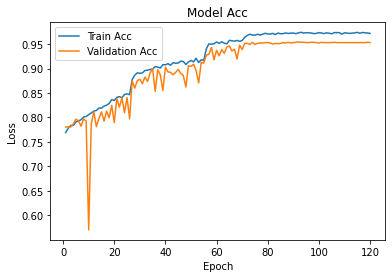

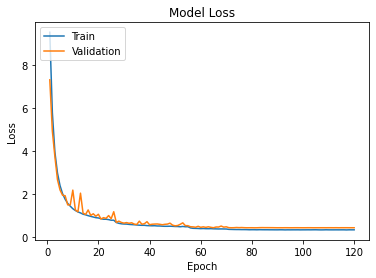

Val Acc:0.9528
Rounded Acc:0.9686
Precision:0.9226 TP/(TP+FP)
Recall:0.9352 TP/(TP+FN)
TP:274 FN:19
FP:23 TN:1020


In [ ]:
# cls

plotLearningCurve_cls(history_0,120)

# predict
y_pred = model_0.predict(X_test)
y_pred_cls = np.argmax(y_pred, axis=-1)
y_test_cls = np.argmax(y_test, axis=-1)

print("Val Acc:{}".format(np.around(accuracy_score(y_test_cls, y_pred_cls),4)))

tp1=0
tn1=0
fp1=0
fn1=0

# <=5 then 0
diff_cls = np.zeros(len(y_test_cls))
for i in range(len(y_test_cls)):
  if y_pred_cls[i]==0 and y_test_cls[i]==0:
    diff_cls[i]=1
    tn1=tn1+1
  elif y_pred_cls[i]!=0 and y_test_cls[i]!=0 and abs(y_pred_cls[i]-y_test_cls[i])<=5:
    diff_cls[i]=1
    tp1=tp1+1
  else:
    diff_cls[i]=0
    if y_pred_cls[i]==0 and y_test_cls[i]!=0:
      fn1=fn1+1
    else:
      fp1=fp1+1

# +- 5 pixels are regarded as correctly-classified
acc = np.count_nonzero(diff_cls)/len(y_test_cls)
print("Rounded Acc:{}".format(np.around(acc,4)))
print("Precision:{} TP/(TP+FP)".format(np.around(tp1/(tp1+fp1),4)))
print("Recall:{} TP/(TP+FN)".format(np.around(tp1/(tp1+fn1),4)))
print("TP:{} FN:{}\nFP:{} TN:{}".format(tp1,fn1,fp1,tn1))


### BoTNet_Origin

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_2D, y_prob, test_size=0.1, random_state=42, shuffle=True)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_train.shape[2], 1)

model_2 = BoTNet_Origin(input_shape = (16, 16, 1))

# model.compile(optimizer=Adam(learning_rate=0.001),loss='mean_squared_error',metrics=['mean_squared_error','mean_absolute_error'])
# model.compile(optimizer=Adam(learning_rate=0.0001),loss='huber_loss',metrics=['mean_squared_error','mean_absolute_error'])
# model.compile(optimizer=Adam(learning_rate=0.0001),loss='log_cosh',metrics=['mean_squared_error','mean_absolute_error'])
# model.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy']) - 150 epochs are enough
model_2.compile(optimizer=Adam(learning_rate=0.0003),loss='categorical_crossentropy',metrics=['accuracy'])

reduce_lr_2 = ReduceLROnPlateau(monitor='val_loss',factor=0.3,patience=3,min_lr=1e-10)
history_2 = model_2.fit(X_train,y_train,epochs=120,validation_data=(X_test,y_test),callbacks=[reduce_lr_2])


Epoch 1/120
376/376 [==============================] - 16s 28ms/step - loss: 45.1321 - accuracy: 0.6126 - val_loss: 19.7704 - val_accuracy: 0.7807
Epoch 2/120
376/376 [==============================] - 9s 23ms/step - loss: 15.8533 - accuracy: 0.7789 - val_loss: 8.6663 - val_accuracy: 0.7807
Epoch 3/120
376/376 [==============================] - 9s 23ms/step - loss: 7.3923 - accuracy: 0.7753 - val_loss: 4.7980 - val_accuracy: 0.7807
Epoch 4/120
376/376 [==============================] - 9s 24ms/step - loss: 4.1690 - accuracy: 0.7822 - val_loss: 3.1999 - val_accuracy: 0.7807
Epoch 5/120
376/376 [==============================] - 8s 22ms/step - loss: 2.7804 - accuracy: 0.7734 - val_loss: 2.5007 - val_accuracy: 0.7807
Epoch 6/120
376/376 [==============================] - 9s 24ms/step - loss: 2.1131 - accuracy: 0.7733 - val_loss: 1.8332 - val_accuracy: 0.7807
Epoch 7/120
376/376 [==============================] - 9s 23ms/step - loss: 1.7065 - accuracy: 0.7754 - val_loss: 1.5262 - val_accur

KeyboardInterrupt: ignored

### ResNet

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_aug, y_aug, test_size=0.1, shuffle=True)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_train.shape[2], 1)

# model = model_2D()
# model = model_2CONV1L()
# model = ResNet(input_shape = (16, 16, 1))
model_1 = ResNet_prob(input_shape = (16, 16, 1))
# model = BoTNet(input_shape = (16, 16, 1))

# model.compile(optimizer=Adam(learning_rate=0.001),loss='mean_squared_error',metrics=['mean_squared_error','mean_absolute_error'])
# model.compile(optimizer=Adam(learning_rate=0.0001),loss='huber_loss',metrics=['mean_squared_error','mean_absolute_error'])
# model.compile(optimizer=Adam(learning_rate=0.0001),loss='log_cosh',metrics=['mean_squared_error','mean_absolute_error'])
model_1.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy']) # 150 epochs are enough
# model_1.compile(optimizer=Adam(learning_rate=0.0003),loss='categorical_crossentropy',metrics=['accuracy'])

reduce_lr_1 = ReduceLROnPlateau(monitor='val_loss',factor=0.3,patience=5,min_lr=1e-20)
history_1 = model_1.fit(X_train,y_train,epochs=150,validation_data=(X_test,y_test),callbacks=[reduce_lr_1])


NameError: ignored

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_2D, y_prob, test_size=0.1, shuffle=True)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_train.shape[2], 1)

# model = model_2D()
# model = model_2CONV1L()
# model = ResNet(input_shape = (16, 16, 1))
model_2 = ResNet_prob(input_shape = (16, 16, 1))
# model = BoTNet(input_shape = (16, 16, 1))

# model.compile(optimizer=Adam(learning_rate=0.001),loss='mean_squared_error',metrics=['mean_squared_error','mean_absolute_error'])
# model.compile(optimizer=Adam(learning_rate=0.0001),loss='huber_loss',metrics=['mean_squared_error','mean_absolute_error'])
# model.compile(optimizer=Adam(learning_rate=0.0001),loss='log_cosh',metrics=['mean_squared_error','mean_absolute_error'])
model_2.compile(optimizer=Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=['accuracy']) # 150 epochs are enough
# model_1.compile(optimizer=Adam(learning_rate=0.0003),loss='categorical_crossentropy',metrics=['accuracy'])

reduce_lr_2 = ReduceLROnPlateau(monitor='val_loss',factor=0.3,patience=5,min_lr=1e-20)
history_2 = model_2.fit(X_train,y_train,epochs=150,validation_data=(X_test,y_test),callbacks=[reduce_lr_2])


Epoch 1/150
376/376 [==============================] - 13s 23ms/step - loss: 38.5565 - accuracy: 0.6784 - val_loss: 34.8284 - val_accuracy: 0.7702
Epoch 2/150
376/376 [==============================] - 7s 17ms/step - loss: 33.2945 - accuracy: 0.7799 - val_loss: 29.5871 - val_accuracy: 0.7710
Epoch 3/150
376/376 [==============================] - 7s 19ms/step - loss: 28.3593 - accuracy: 0.7896 - val_loss: 25.1357 - val_accuracy: 0.7695
Epoch 4/150
376/376 [==============================] - 7s 18ms/step - loss: 24.0247 - accuracy: 0.7877 - val_loss: 21.3698 - val_accuracy: 0.7747
Epoch 5/150
376/376 [==============================] - 7s 18ms/step - loss: 20.4039 - accuracy: 0.7880 - val_loss: 18.1334 - val_accuracy: 0.7784
Epoch 6/150
376/376 [==============================] - 7s 18ms/step - loss: 17.3906 - accuracy: 0.7971 - val_loss: 15.5850 - val_accuracy: 0.7844
Epoch 7/150
376/376 [==============================] - 7s 18ms/step - loss: 14.9741 - accuracy: 0.8030 - val_loss: 13.5415 

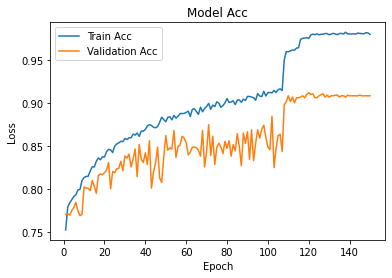

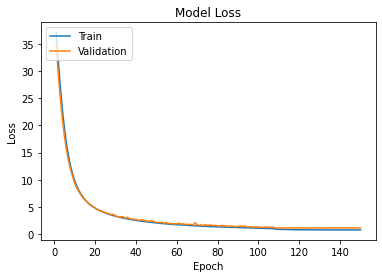

Val Acc:0.9087
Rounded Acc:0.9506
Precision:0.8974 TP/(TP+FP)
Recall:0.8856 TP/(TP+FN)
TP:271 FN:35
FP:31 TN:999


In [ ]:
# cls

plotLearningCurve_cls(history_2,150)

# predict
y_pred = model_2.predict(X_test)
y_pred_cls = np.argmax(y_pred, axis=-1)
y_test_cls = np.argmax(y_test, axis=-1)

print("Val Acc:{}".format(np.around(accuracy_score(y_test_cls, y_pred_cls),4)))

tp1=0
tn1=0
fp1=0
fn1=0

# <=5 then 0
diff_cls = np.zeros(len(y_test_cls))
for i in range(len(y_test_cls)):
  if y_pred_cls[i]==0 and y_test_cls[i]==0:
    diff_cls[i]=1
    tn1=tn1+1
  elif y_pred_cls[i]!=0 and y_test_cls[i]!=0 and abs(y_pred_cls[i]-y_test_cls[i])<=5:
    diff_cls[i]=1
    tp1=tp1+1
  else:
    diff_cls[i]=0
    if y_pred_cls[i]==0 and y_test_cls[i]!=0:
      fn1=fn1+1
    else:
      fp1=fp1+1

# +- 5 pixels are regarded as correctly-classified
acc = np.count_nonzero(diff_cls)/len(y_test_cls)
print("Rounded Acc:{}".format(np.around(acc,4)))
print("Precision:{} TP/(TP+FP)".format(np.around(tp1/(tp1+fp1),4)))
print("Recall:{} TP/(TP+FN)".format(np.around(tp1/(tp1+fn1),4)))
print("TP:{} FN:{}\nFP:{} TN:{}".format(tp1,fn1,fp1,tn1))


## Save and load model [Only conduct when current model is better]

In [ ]:
from keras.models import load_model

model_0.save("/content/drive/My Drive/Colab Notebooks/BoTNet.h5")

# model.save("/content/drive/My Drive/Colab Notebooks/ResNet_cls.h5")
# model = load_model("/content/drive/My Drive/Colab Notebooks/ResNet_cls.h5")
model_0 = load_model("/content/drive/My Drive/Colab Notebooks/BoTNet.h5")

In [ ]:

# predict
y_pred = model_0.predict(X_test)
y_pred_cls = np.argmax(y_pred, axis=-1)
y_test_cls = np.argmax(y_test, axis=-1)

print("Val Acc:{}".format(np.around(accuracy_score(y_test_cls, y_pred_cls),4)))

tp1=0
tn1=0
fp1=0
fn1=0

# <=5 then 0
diff_cls = np.zeros(len(y_test_cls))
for i in range(len(y_test_cls)):
  if y_pred_cls[i]==0 and y_test_cls[i]==0:
    diff_cls[i]=1
    tn1=tn1+1
  elif y_pred_cls[i]!=0 and y_test_cls[i]!=0 and abs(y_pred_cls[i]-y_test_cls[i])<=5:
    diff_cls[i]=1
    tp1=tp1+1
  else:
    diff_cls[i]=0
    if y_pred_cls[i]==0 and y_test_cls[i]!=0:
      fn1=fn1+1
    else:
      fp1=fp1+1

# +- 5 pixels are regarded as correctly-classified
acc = np.count_nonzero(diff_cls)/len(y_test_cls)
print("Rounded Acc:{}".format(np.around(acc,4)))
print("Precision:{} TP/(TP+FP)".format(np.around(tp1/(tp1+fp1),4)))
print("Recall:{} TP/(TP+FN)".format(np.around(tp1/(tp1+fn1),4)))
print("TP:{} FN:{}\nFP:{} TN:{}".format(tp1,fn1,fp1,tn1))


Val Acc:0.9528
Rounded Acc:0.9686
Precision:0.9226 TP/(TP+FP)
Recall:0.9352 TP/(TP+FN)
TP:274 FN:19
FP:23 TN:1020


max: 16
mean: 1.8869760479041917
min: 0
median: 0.0


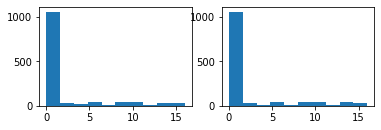

In [ ]:
print("max:",np.max(y_pred_cls))
print("mean:",np.mean(y_pred_cls))
print("min:",np.min(y_pred_cls))
print("median:",np.median(y_pred_cls))

plt.figure(1)
plt.subplot(221)
plt.hist(y_pred_cls)
plt.subplot(222)
plt.hist(y_test_cls)
plt.show()

array([[1020,   11,    0,    0,    2,    2,    0,    0,    0,    0,    0,
           0,    2,    2,    1,    3,    0],
       [   6,    9,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [   0,    0,    8,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [   1,    0,    0,   18,    0,    2,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    1,   13,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,   32,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    1,    8,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    1,    0,   12,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0

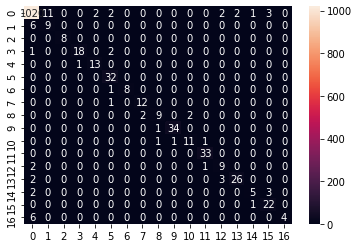

In [ ]:
CM = confusion_matrix(y_test_cls,y_pred_cls)
sns.heatmap(CM,annot=True,fmt='.20g')
confusion_matrix(y_test_cls,y_pred_cls)

In [ ]:
print("precisioin:",precision_score(y_true=y_test_cls,y_pred=y_pred_cls,average='micro'))
print("recall:",recall_score(y_true=y_test_cls,y_pred=y_pred_cls,average='micro'))

precisioin: 0.9528443113772455
recall: 0.9528443113772455


## Visualize

In [ ]:
print("max:",np.max(y_2D))
print("min:",np.min(y_2D))
print("non zero:",np.count_nonzero(y_2D))
print("total:",len(y_2D))

max: 16
min: 0
non zero: 2952
total: 13360


In [ ]:
y_pred = model_0.predict(X_2D)
y_pred = np.around(y_pred)
y_pred = y_pred.astype(int)
y_pred_li = []
for i in range(y_pred.shape[0]):
  temp = np.argmax(y_pred[i])
  y_pred_li.append(temp)
y_pred = y_pred_li

print("max:",np.max(y_pred))
print("min:",np.min(y_pred))
print("non zero:",np.count_nonzero(y_pred))
print("total:",len(y_pred))


for i in range(len(y_pred)):
  if y_pred[i]>16:
    y_pred[i]=0

print("max:",np.max(y_pred))
print("min:",np.min(y_pred))
print("non zero:",np.count_nonzero(y_pred))
print("total:",len(y_pred))

max: 16
min: 0
non zero: 3061
total: 13360
max: 16
min: 0
non zero: 3061
total: 13360


In [ ]:
location = []

for i in range(len(y_pred)):
  if y_pred[i]!=0:
    temp_id = i*16+y_pred[i]-1
    temp_loc = location_2v[temp_id]
    location.append(temp_loc)

print(len(location))

3061


In [ ]:
loc = []

for i in location:
  # print(i)
  # print(i[0])
  if i[0]>180:
    a = i[0]-360
  else:
    a = i[0]
  b = i[1]
  loc.append((a,b))

print(loc)
print(len(loc))

[(118.829793, 21.164154), (118.829793, 21.164154), (118.829793, 21.164154), (118.90463899999999, 20.989366), (118.829793, 21.164154), (118.90463899999999, 20.989366), (118.829793, 21.164154), (118.90463899999999, 20.989366), (118.829793, 21.164154), (118.90463899999999, 20.989366), (118.829793, 21.164154), (118.90463899999999, 20.989366), (118.829793, 21.164154), (118.90463899999999, 20.989366), (118.829793, 21.164154), (118.829793, 21.164154), (118.829793, 21.164154), (118.829793, 21.164154), (118.90463899999999, 20.989366), (118.829793, 21.164154), (118.90463899999999, 20.989366), (118.90463899999999, 20.989366), (118.829793, 21.164154), (118.90463899999999, 20.989366), (118.90463899999999, 20.989366), (118.90463899999999, 20.989366), (118.90463899999999, 20.989366), (118.90463899999999, 20.989366), (118.90463899999999, 20.989366), (118.90463899999999, 20.989366), (118.829793, 21.164154), (118.82451499999999, 21.176462), (118.829793, 21.164154), (118.90463899999999, 20.989366), (116.

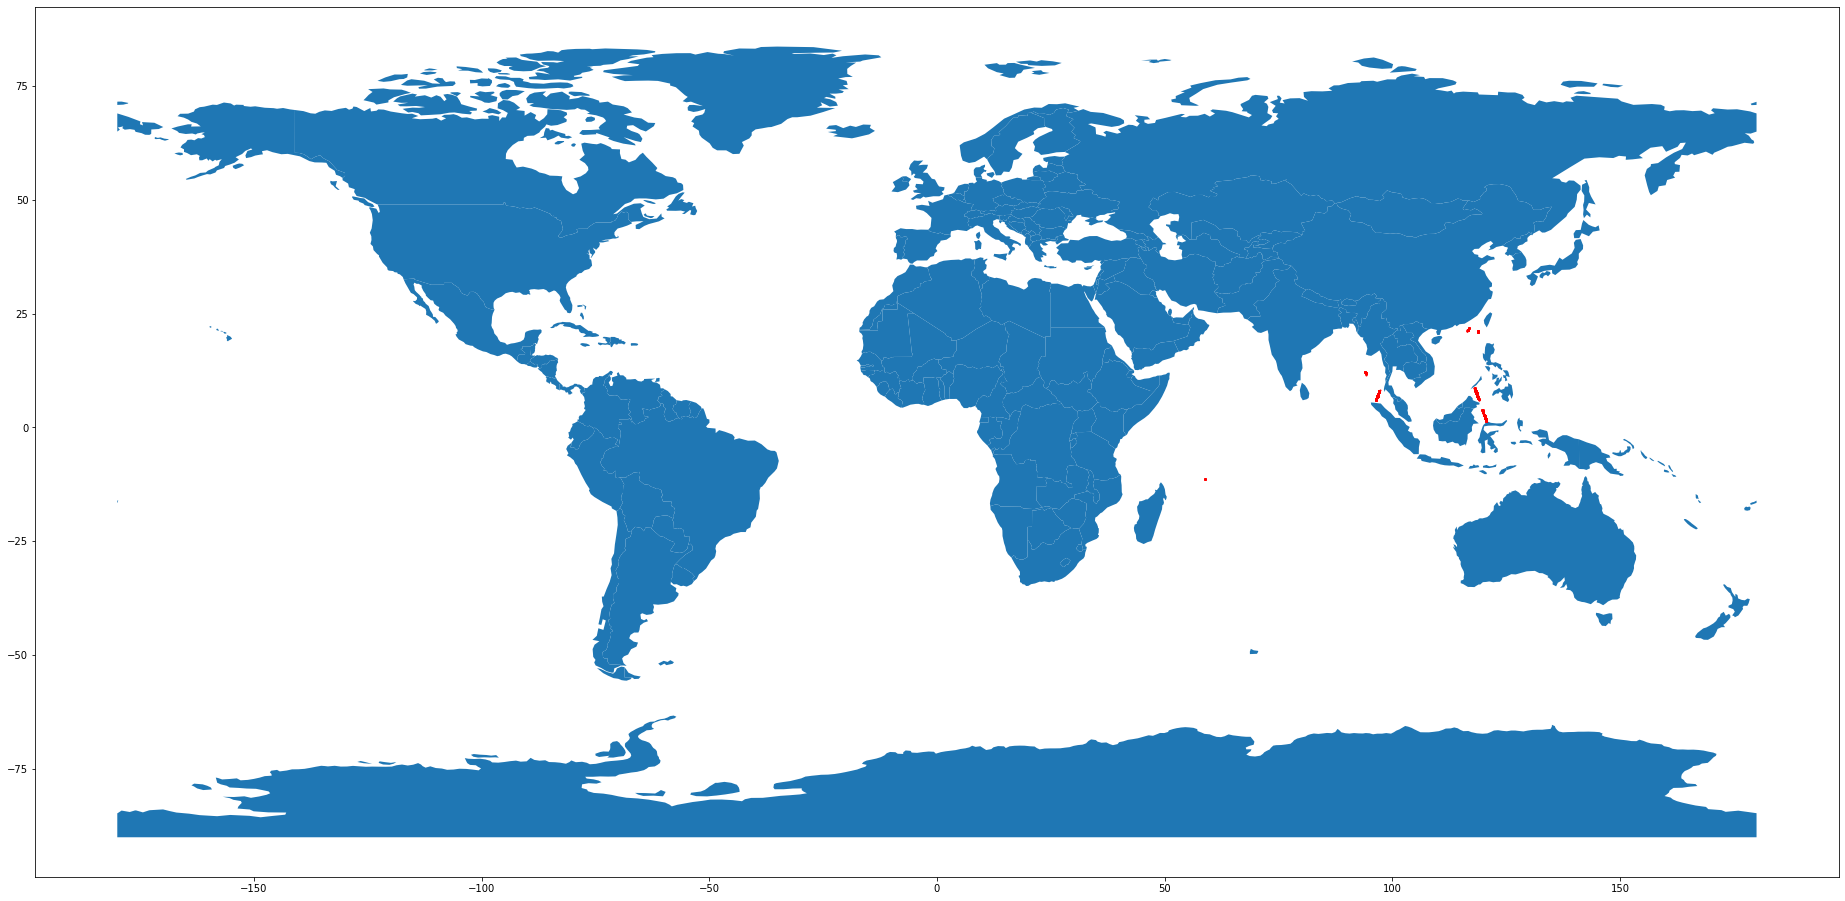

In [ ]:
# prediction

df = pd.DataFrame(loc, columns=['longitude','latitude'])

df.to_csv("/content/drive/My Drive/Colab Notebooks/location_2D.csv")

df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/location_2D.csv")

geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = GeoDataFrame(df, geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(36, 16)), marker='o', color='red', markersize=1)



213760
2977


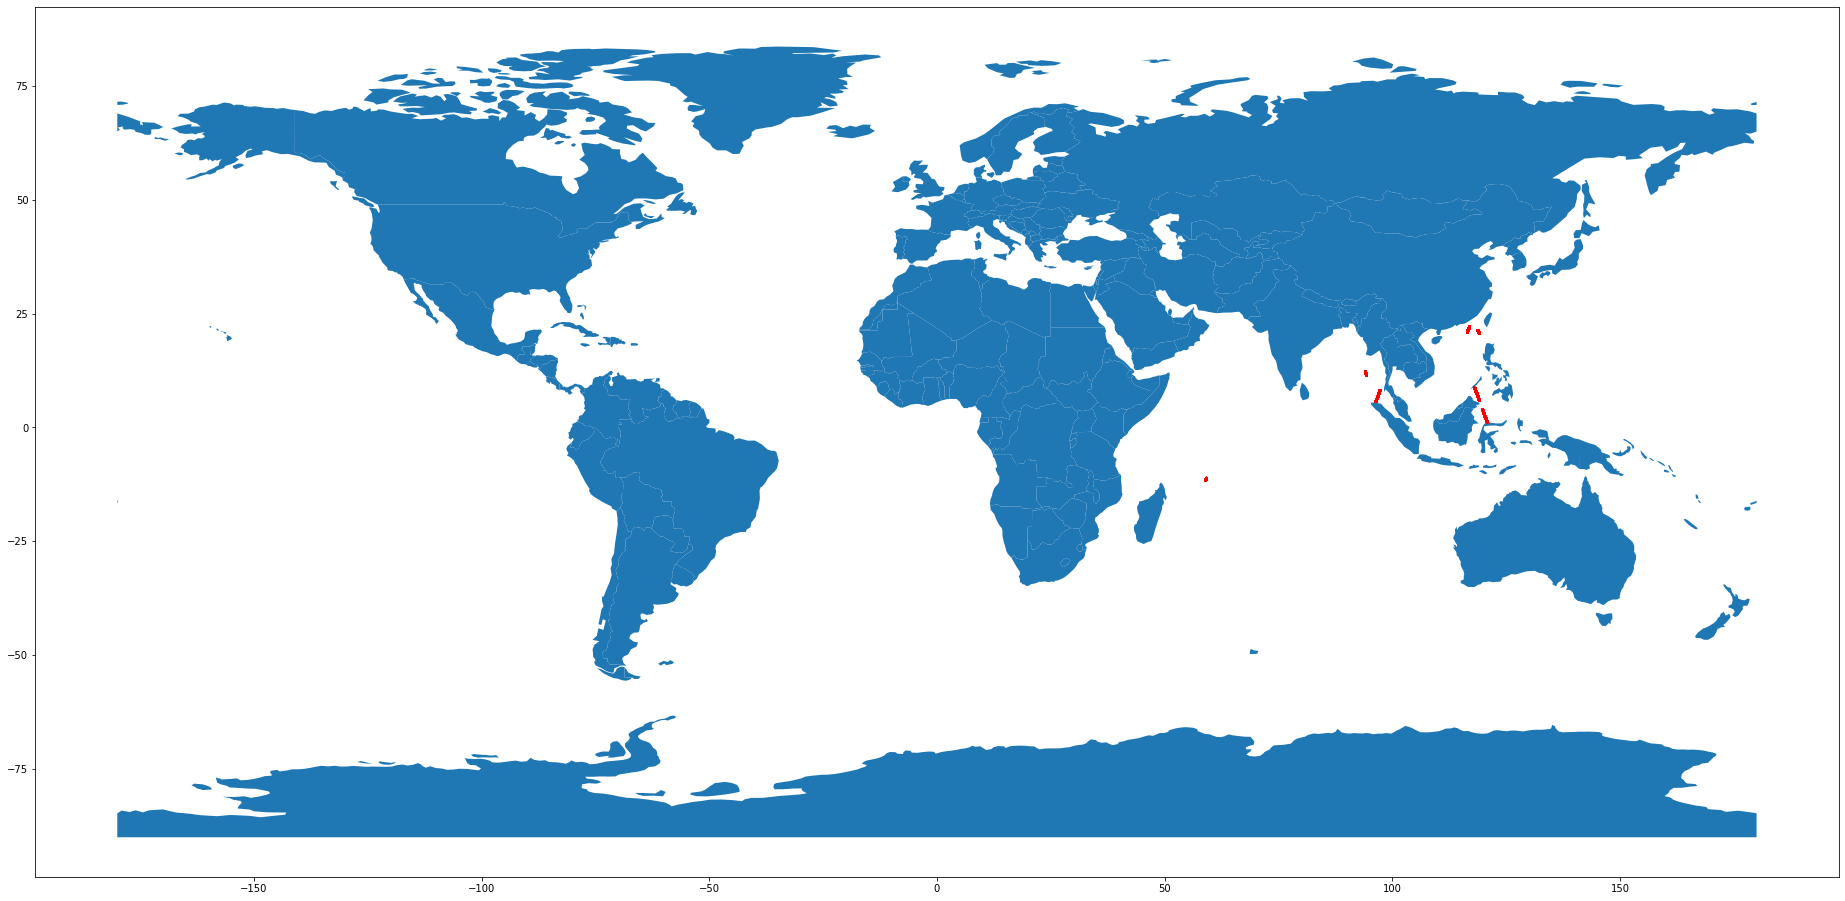

In [ ]:
# origin

print(len(location_2v))
print(len(loc))

df = pd.DataFrame(location_2v, columns=['longitude','latitude'])

df.to_csv("/content/drive/My Drive/Colab Notebooks/location_2D.csv")

df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/location_2D.csv")

geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = GeoDataFrame(df, geometry=geometry)   

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(36, 16)), marker='o', color='red', markersize=1)


# for i in range(10):
#   print(location_2v[i])
# for j in range(10):
#   print(loc[j])

# CNN - Classification for globe

## prediction

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential,activations
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization,Dropout,Dense,Flatten,Conv1D,Conv2D,MaxPooling1D,MaxPooling2D,GlobalMaxPooling2D,AveragePooling2D,Activation,Input,Add,Dense,ZeroPadding2D,Flatten
from tensorflow.keras.optimizers import Adam
from keras.initializers import glorot_uniform
from keras.models import Model
from keras import metrics
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def plotLearningCurve(history,epochs):
  epochRange = range(1,epochs+1)
  plt.plot(epochRange,history.history['accuracy'])
  plt.plot(epochRange,history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('acc')
  plt.legend(['Train acc','Validation acc'],loc='upper left')
  plt.show()

  plt.plot(epochRange,history.history['loss'])
  plt.plot(epochRange,history.history['val_loss'])
  plt.title('Model Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['Train','Validation'],loc='upper left')
  
  plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_cls, y_cls, test_size=0.1, random_state=42, shuffle=True)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_train.shape[2], 1)

model_2D=Sequential()
model_2D.add(Conv2D(16,3,activation='relu',input_shape=X_train[0].shape,kernel_regularizer='l2',kernel_initializer="he_uniform"))
model_2D.add(BatchNormalization())
model_2D.add(MaxPooling2D(pool_size=3,strides=1,padding='same'))

model_2D.add(Conv2D(32,3,activation='relu',kernel_regularizer='l2',kernel_initializer="he_uniform"))
model_2D.add(BatchNormalization())
model_2D.add(MaxPooling2D(pool_size=3,strides=1,padding='same'))

model_2D.add(Conv2D(64,3,activation='relu',kernel_regularizer='l2',kernel_initializer="he_uniform"))
model_2D.add(BatchNormalization())
model_2D.add(MaxPooling2D(pool_size=3,strides=1,padding='same'))

model_2D.add(Conv2D(128,3,activation='relu',kernel_regularizer='l2',kernel_initializer="he_uniform"))
model_2D.add(BatchNormalization())
model_2D.add(MaxPooling2D(pool_size=3,strides=1,padding='same'))

model_2D.add(Conv2D(256,3,activation='relu',kernel_regularizer='l2',kernel_initializer="he_uniform"))
model_2D.add(BatchNormalization())
model_2D.add(MaxPooling2D(pool_size=3,strides=1,padding='same'))

# model_2D.add(Conv2D(512,3,activation='relu',kernel_regularizer='l2',kernel_initializer="he_uniform"))
# model_2D.add(BatchNormalization())
# model_2D.add(MaxPooling2D(pool_size=3,strides=1,padding='same'))

model_2D.add(Flatten())
model_2D.add(Dense(64,activation='relu',kernel_regularizer='l2',kernel_initializer="he_uniform"))
# model_2D.add(Dropout(0.1))
model_2D.add(Dense(32,activation='relu',kernel_regularizer='l2',kernel_initializer="he_uniform"))
# model_2D.add(Dropout(0.1))
model_2D.add(Dense(17,activation='relu',kernel_regularizer='l2',kernel_initializer="he_uniform"))
model_2D.add(Dense(1,activation='sigmoid'))

# model_2.summary()

model_2D.compile(optimizer=Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics=['accuracy'])
reduce_lr_2D = ReduceLROnPlateau(monitor='val_loss',factor=0.9,patience=5,min_lr=1e-10)
history_2D = model_2D.fit(X_train,y_train,epochs=150,validation_data=(X_test,y_test),callbacks=[reduce_lr_2D])


Epoch 1/150
376/376 [==============================] - 3s 6ms/step - loss: 11.8196 - accuracy: 0.8512 - val_loss: 9.1275 - val_accuracy: 0.8915
Epoch 2/150
376/376 [==============================] - 2s 5ms/step - loss: 8.2547 - accuracy: 0.8928 - val_loss: 6.1056 - val_accuracy: 0.8990
Epoch 3/150
376/376 [==============================] - 2s 5ms/step - loss: 5.5924 - accuracy: 0.8912 - val_loss: 4.2750 - val_accuracy: 0.8982
Epoch 4/150
376/376 [==============================] - 2s 6ms/step - loss: 3.9574 - accuracy: 0.8914 - val_loss: 3.1602 - val_accuracy: 0.8967
Epoch 5/150
376/376 [==============================] - 2s 5ms/step - loss: 2.9528 - accuracy: 0.8924 - val_loss: 2.4274 - val_accuracy: 0.9057
Epoch 6/150
376/376 [==============================] - 2s 5ms/step - loss: 2.3168 - accuracy: 0.8992 - val_loss: 2.0050 - val_accuracy: 0.9139
Epoch 7/150
376/376 [==============================] - 2s 6ms/step - loss: 1.9157 - accuracy: 0.9002 - val_loss: 1.7151 - val_accuracy: 0.899

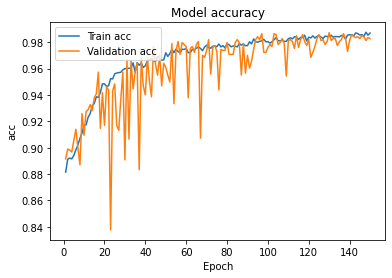

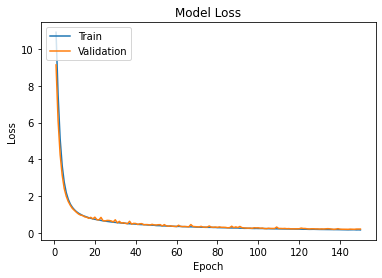

In [ ]:
plotLearningCurve(history_2D,150)

In [ ]:
model_2D.save("/content/drive/My Drive/Colab Notebooks/CNN_cls.h5")